# Residual Connections in Deep Neural Networks

This notebook demonstrates the implementation and training of deep neural networks using the PyTorch framework. The primary focus is on Convolutional Neural Networks (CNNs), specifically the ResNet architecture. The experiments revolve around the MNIST dataset, which is a collection of handwritten digits and lastly PlantVillage Dataset is used as real world dataset to test the model. The code aims to investigate the performance of deep networks, both with and without residual connections, and to visualize aspects like gradient magnitudes across epochs.

Flow of the code:
- Visualising and Understanding Vanishing Gradient Problem
    - Analysis with simple network and complex network
- Visualising and Understanding Exploding Gradient Problem
    - Analysis with simple network and complex network
- Implementing Model without Residual Connection
    - Mimicing all network architecture of ResNet without Residual Connection
    - Using MNIST dataset
- Implementing Model with Residual Connection (ResNet)
    - Using MNIST datset
- Implementing ResNet50 in PlantVillage Dataset to detect 15 different diseases in plant to test the model for real world dataset.


*This assignment was suggested on Week 7 Module. All code related part is explained here and theoritical part is explained in journal.*

#Vanishing Gradient Problem

##Imports
Importing essential libraries and modules required for building and training neural network models using the PyTorch framework.

Key Imports:
- torch: Main library for tensor computation and deep learning functionalities.
- torch.nn: Provides classes to build neural network architectures.
- torch.nn.functional: Stateless functions, such as activation and loss functions.
- torch.optim: Optimization algorithms like SGD, Adam, etc.
- matplotlib.pyplot: Used for data visualization.
- numpy: For numerical operations on arrays.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## Simple Deep CNN Model
DeepCNN represents a simple deep convolutional neural network (CNN). This network is constructed dynamically based on the num_layers parameter passed during its initialization.

In [ ]:
class DeepCNN(nn.Module):
    def __init__(self, num_layers):
        super(DeepCNN, self).__init__()  # Initialize the superclass (nn.Module)
        self.layers = nn.ModuleList()  # Initialize an empty ModuleList to hold convolutional layers
        for _ in range(num_layers):  # Loop to add convolutional layers based on the num_layers value
            # Append a 2D convolutional layer with 1 input channel, 1 output channel,
            # kernel size of 3, stride of 1, and padding of 1
            self.layers.append(nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1))

    def forward(self, x):  # Define the forward pass
        for layer in self.layers:  # Loop over each convolutional layer
            x = torch.tanh(layer(x))  # Apply the convolutional layer followed by tanh activation
        return x  # Return the output tensor


### Examine the Model
Creating an input tensor, initializing the DeepCNN model, performing a forward pass, computing a loss, and then calculating the gradients via backpropagation. The gradients of each convolutional layer are then stored in a list.

In [ ]:
# Create a random tensor simulating a 28x28 grayscale image (1 channel)
input_tensor = torch.randn(1, 1, 28, 28)

# Initialize the DeepCNN model with 20 convolutional layers
model = DeepCNN(num_layers=20)

# Perform a forward pass through the model
output = model(input_tensor)

# Compute the Mean Squared Error (MSE) loss between the model's output and a tensor of zeros of the same shape
loss = F.mse_loss(output, torch.zeros_like(output))

# Zero out any existing gradients in the model
model.zero_grad()

# Perform backpropagation to compute gradients with respect to the loss
loss.backward()

# Extract and store the average gradient magnitude for each convolutional layer in the model
gradients = []
for layer in model.layers:
    gradients.append(layer.weight.grad.abs().mean().item())


### Vanishing Gradient Graph
Visualising the gradient. This is a simple example but we can clearly see gradients are diminishing as we move from the last layer to the first, it indicates a vanishing gradient problem. In the last layer the gradient was arounf 0.12 which decreased to 0.02 and as we move forward we can see it's nearly zero from the layer 12.

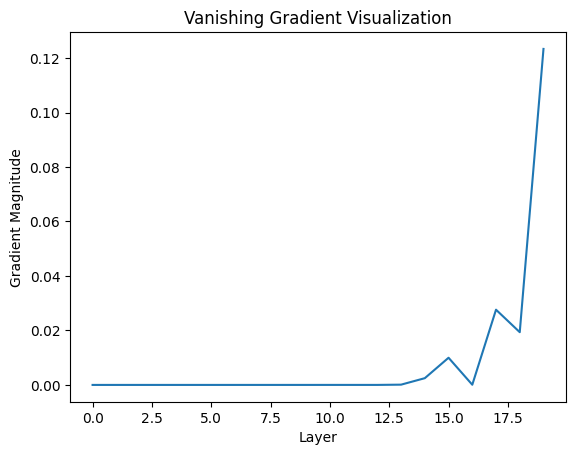

In [ ]:
plt.plot(gradients)
plt.xlabel('Layer')
plt.ylabel('Gradient Magnitude')
plt.title('Vanishing Gradient Visualization')
plt.show()

## Complex Deep CNN Model
This is custom deep convolutional neural network. This architecture is made complex intentionally to show vanishing gradient problem which comprises multiple convolutional layers, pooling layers, and a final fully connected layer.

1. **Initialization (`__init__`)**:
    - The network starts with a convolutional layer (`Conv2d`) that takes a single-channel input (like a grayscale image) and produces 8 feature maps. The kernel size is 3x3, and padding is applied to ensure the output size remains consistent.
    - The `ReLU` activation function is applied after the convolution. We can use other as well, preferably tanh  as it shows more vanishing gradient problem. (But it was used earlier so ReLU is selected here)
    - 18 additional convolutional layers with `ReLU` activations

2. **Forward Pass (`forward`)**:
    - The input tensor `x` is passed through the convolutional layers.
    - The tensor is then flattened to feed into the fully connected layer.
    - The final output is produced by the fully connected layer, which can then be used with a suitable loss function for classification tasks.



In [ ]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()

        # Define the convolutional layers and activations
        layers = []
        layers.append(nn.Conv2d(1, 8, 3, padding=1))
        layers.append(nn.ReLU())
        for i in range(18):  # Add 18 additional convolutional layers
            layers.append(nn.Conv2d(8, 8, 3, padding=1))
            layers.append(nn.ReLU())
            if i % 9 == 8:  # Add max-pooling every 9 layers
                layers.append(nn.MaxPool2d(2, stride=2))
        self.convs = nn.Sequential(*layers)

        # Define the fully connected layer
        self.fc = nn.Linear(8 * 7 * 7, 10)  # Map the feature vector to 10 classes

    def forward(self, x):
        x = self.convs(x)  # Pass the input through the convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)  # Pass the tensor through the fully connected layer
        return x

### Data Preparation
Stochastic Gradient Descent (SGD) optimizer is selected with a learning rate of 0.01. SGD is a commonly used optimization algorithm for training neural networks, and the choice of learning rate affects the step size in updating the weights during training.

In [ ]:
# Generate random dataset
data = torch.randn(100, 1, 28, 28)  # Simulated image data
labels = torch.randint(0, 10, (100,))  # Random labels for the simulated data

# Initialize the DeepCNN model
model = DeepCNN()

# Define the optimizer for training
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Specify the loss function for training
criterion = nn.CrossEntropyLoss()

### Train the Model
DeepCNN model uses the synthetic dataset. The training loop runs for a specified number of epochs (50), during which the model is updated using the backpropagation algorithm. The code captures the gradient magnitudes for the model's parameters at specific intervals and calculates the accuracy of the model for each epoch.

In [ ]:
epoch_gradients = []
all_gradients = []
num_epochs = 50
layer_names = []

# Record loss and accuracy for each epoch
epoch_losses = []
epoch_accuracies = []

# Capture the names of model parameters
for name, param in model.named_parameters():
    layer_names.append(name)

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Record loss and compute accuracy
    epoch_losses.append(loss.item())
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels)
    epoch_accuracies.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}, Accuracy: {accuracy:.6f}")

    # Store gradients every 10 epochs
    if epoch % 10 == 0:
        gradients = {}
        for name, param in model.named_parameters():
            if param.grad is not None:
                gradients[name] = param.grad.view(-1).norm().item()
        epoch_gradients.append(gradients)

    # Record gradients for the epoch
    gradients_pe = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            gradients_pe[name] = param.grad.view(-1).norm().item()
    all_gradients.append(gradients_pe)

Epoch 1/50, Loss: 2.299846, Accuracy: 0.120000
Epoch 2/50, Loss: 2.299745, Accuracy: 0.120000
Epoch 3/50, Loss: 2.299644, Accuracy: 0.120000
Epoch 4/50, Loss: 2.299543, Accuracy: 0.120000
Epoch 5/50, Loss: 2.299443, Accuracy: 0.120000
Epoch 6/50, Loss: 2.299343, Accuracy: 0.120000
Epoch 7/50, Loss: 2.299244, Accuracy: 0.120000
Epoch 8/50, Loss: 2.299145, Accuracy: 0.120000
Epoch 9/50, Loss: 2.299048, Accuracy: 0.120000
Epoch 10/50, Loss: 2.298949, Accuracy: 0.120000
Epoch 11/50, Loss: 2.298852, Accuracy: 0.120000
Epoch 12/50, Loss: 2.298755, Accuracy: 0.120000
Epoch 13/50, Loss: 2.298659, Accuracy: 0.120000
Epoch 14/50, Loss: 2.298563, Accuracy: 0.120000
Epoch 15/50, Loss: 2.298467, Accuracy: 0.120000
Epoch 16/50, Loss: 2.298372, Accuracy: 0.120000
Epoch 17/50, Loss: 2.298277, Accuracy: 0.120000
Epoch 18/50, Loss: 2.298182, Accuracy: 0.120000
Epoch 19/50, Loss: 2.298088, Accuracy: 0.120000
Epoch 20/50, Loss: 2.297995, Accuracy: 0.120000
Epoch 21/50, Loss: 2.297901, Accuracy: 0.120000
E

### Acc/Loss Graph
The training loss and training accuracy, as the DeepCNN model progresses through the epochs. It uses the matplotlib library to plot these metrics side-by-side for a clear comparative view.

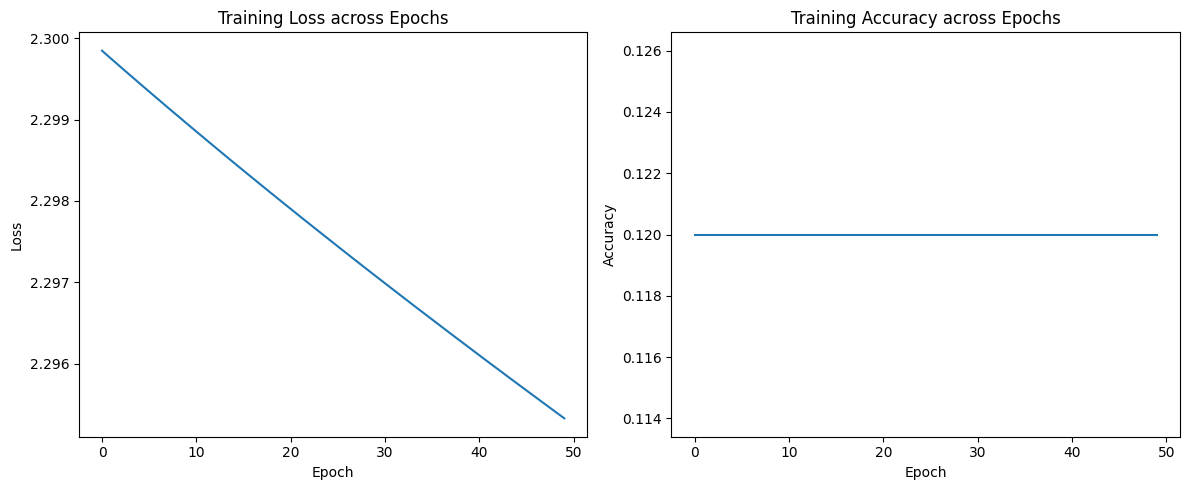

In [ ]:
# Plotting Training Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_losses)
plt.title("Training Loss across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plotting Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies)
plt.title("Training Accuracy across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


As we can see in the above graph:
Training Loss across Epochs: Loss decreases linearly but with a very minimal rate over 50 epochs.
Training Accuracy across Epochs: Accuracy remains constant at about 12% throughout the 50 epochs.

This indicates model isnot performing well and not learning. Let's visualise the graph for the gradients.

 ### Vanishing Gradient Graph
 Here, the gradient magnitudes of the DeepCNN model's parameters across various epochs are plotted. The visualizations are presented in both a normal scale and a log scale, offering different perspectives on the gradient magnitudes.

Gradient Visualization Across Epochs:

- Two side-by-side plots are created, one displaying the gradient magnitudes on a normal scale and the other on a log scale.
- Each line in the plots represents the gradient magnitudes for a specific epoch, with different colors for each epoch.
- The log scale can help emphasize variations in smaller gradient magnitudes, which may not be clearly visible on the normal scale.

Average Gradient Visualization:
- Again, two side-by-side plots illustrate the average gradient magnitudes, with one on a normal scale and the other on a log scale.
- These plots provide an overview of the average behavior of the gradients for the model's parameters.

Insights:
- Similar to above, as we move from last to first layer the gradient are decreasing and varies from 10^(-1) to 10^(-9) which is a clear vanishing gradient problem in the network (considering the accuracy of the model as well.)

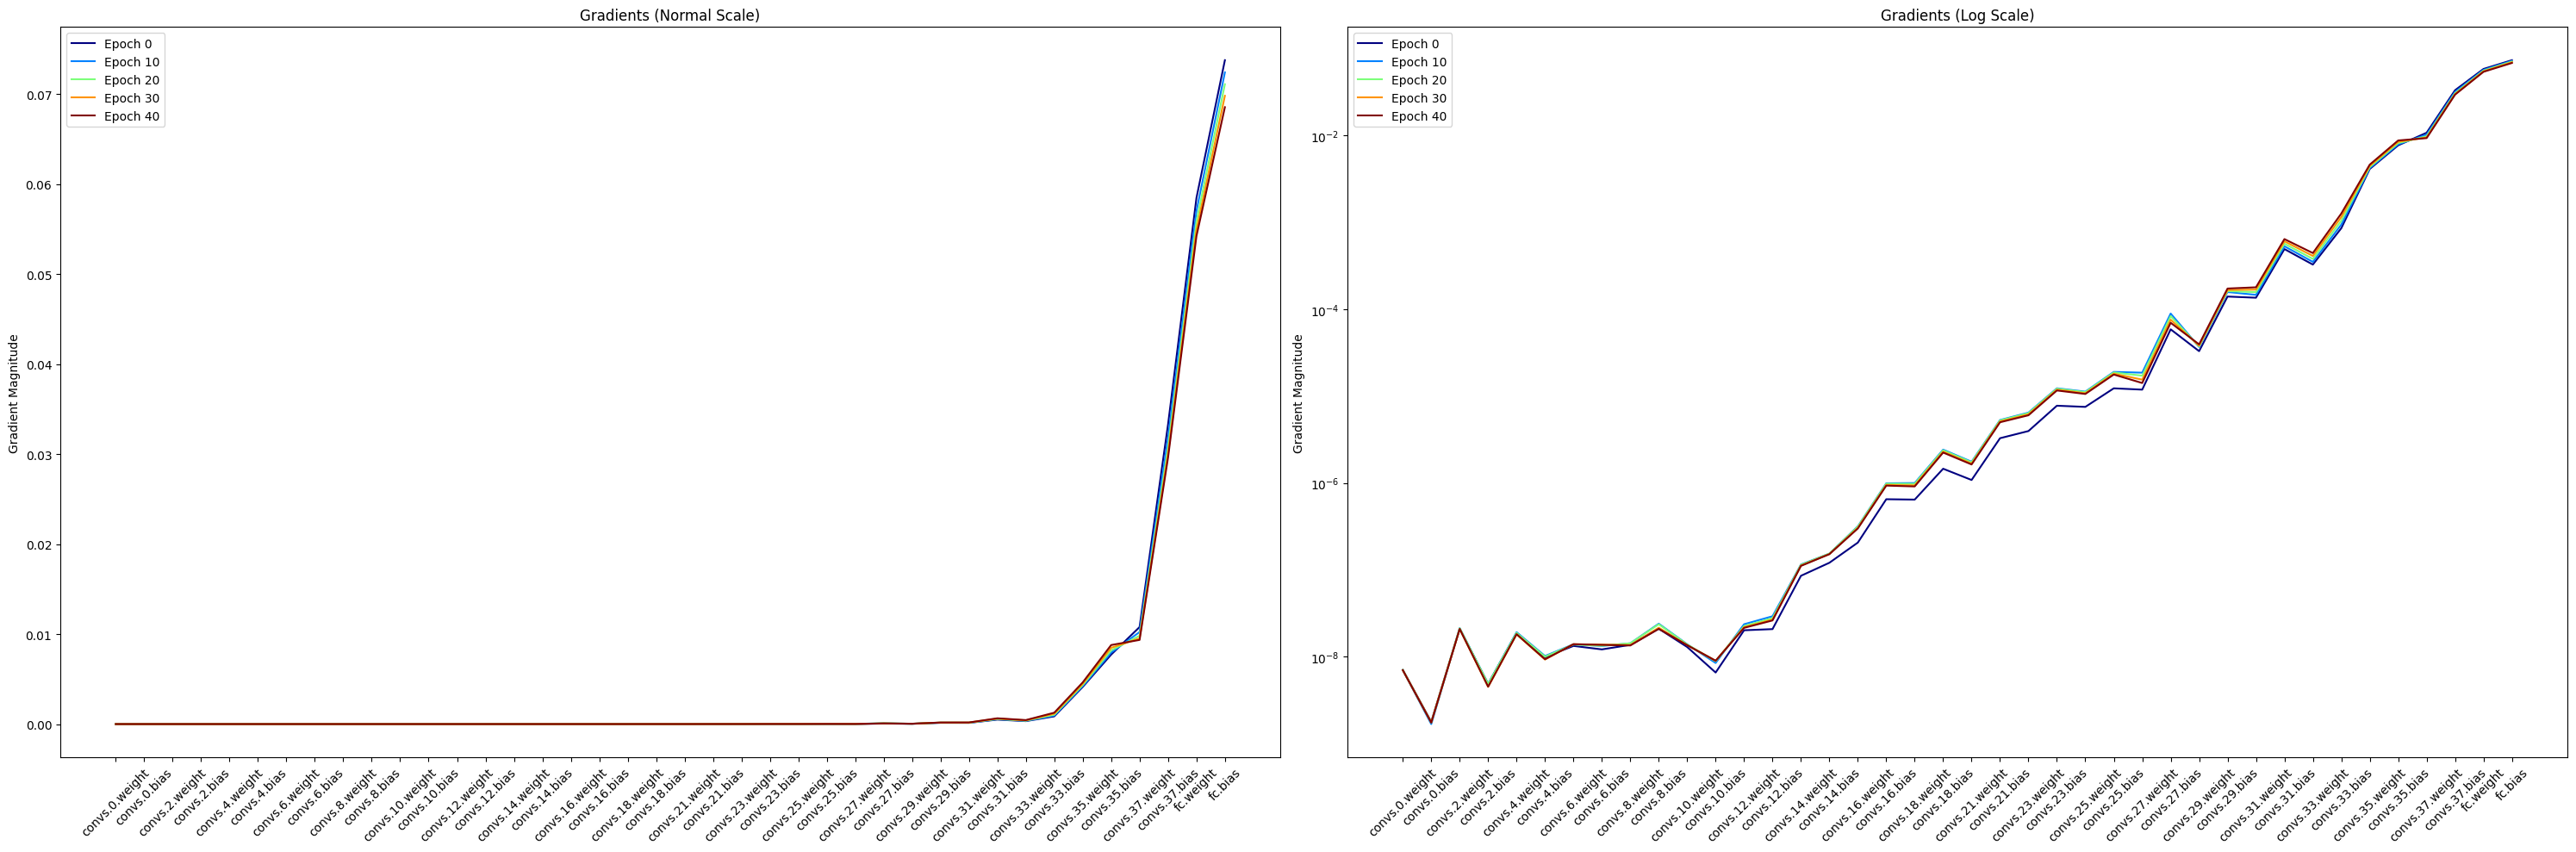

In [ ]:
# The key of the dictionary is the name of the parameter and the value is the gradient magnitude.

num_epochs = len(epoch_gradients)

# Create a colormap to have distinct colors for each epoch
colors = plt.cm.jet(np.linspace(0, 1, num_epochs))

fig, axes = plt.subplots(1, 2, figsize=(30, 10))  # One row with 2 columns (Normal Scale and Log Scale)

for i, grads in enumerate(epoch_gradients):
    names = list(grads.keys())
    values = list(grads.values())

    # Normal Scale
    axes[0].plot(names, values, linestyle='-', color=colors[i], label=f"Epoch {i*10}")
    axes[0].set_title("Gradients (Normal Scale)")
    axes[0].set_ylabel("Gradient Magnitude")
    axes[0].tick_params(axis='x', rotation=45)

    # Log Scale
    axes[1].plot(names, values, linestyle='-', color=colors[i], label=f"Epoch {i*10}")
    axes[1].set_title("Gradients (Log Scale)")
    axes[1].set_ylabel("Gradient Magnitude")
    axes[1].set_yscale("log")
    axes[1].tick_params(axis='x', rotation=45)

axes[0].legend(loc="upper left")
axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

Gradients (Normal Scale) - Left Graph: Gradient magnitudes are initially high and rapidly decrease to near zero for all epochs.

Gradients (Log Scale) - Right Graph: Gradient magnitudes, on a logarithmic scale, show a stair-step pattern.

The gradients for different epochs converge but vary slightly.
In both graphs, the gradients are plotted for different convolutional layers/blocks of a neural network.

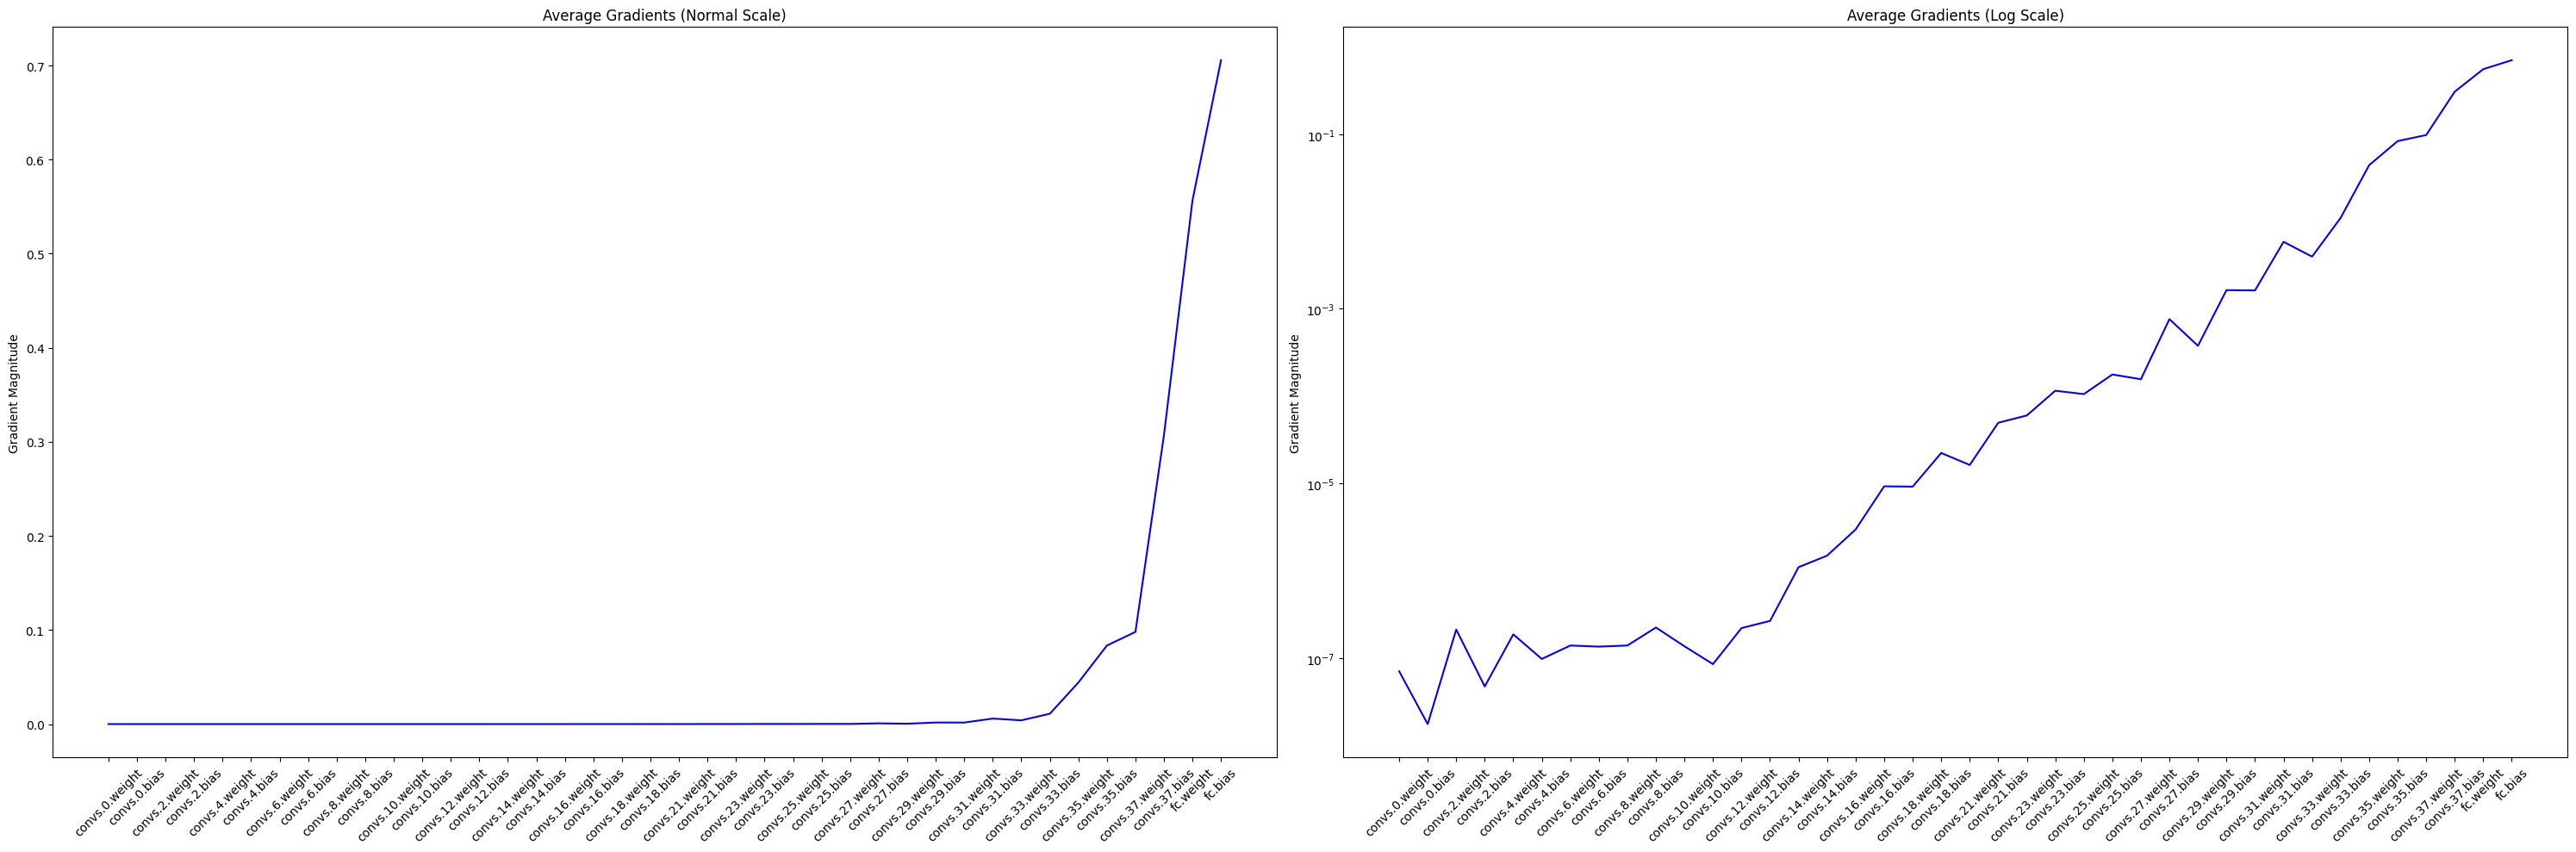

In [ ]:
# Initialize a dictionary to store the accumulated gradient magnitudes
avg_gradients = {name: 0 for name in all_gradients[0].keys()}

# Sum up the gradients over all epochs
for gradients in all_gradients:
    for name, value in gradients.items():
        avg_gradients[name] += value

# Divide by the number of epochs to get the average
for name in avg_gradients.keys():
    avg_gradients[name] /= num_epochs


# Extract parameter names and their corresponding average gradients
names = list(avg_gradients.keys())
values = list(avg_gradients.values())

fig, axes = plt.subplots(1, 2, figsize=(30, 10))  # One row with 2 columns (Normal Scale and Log Scale)

# Normal Scale
axes[0].plot(names, values, linestyle='-', color='b')
axes[0].set_title("Average Gradients (Normal Scale)")
axes[0].set_ylabel("Gradient Magnitude")
axes[0].tick_params(axis='x', rotation=45)

# Log Scale
axes[1].plot(names, values, linestyle='-', color='b')
axes[1].set_title("Average Gradients (Log Scale)")
axes[1].set_ylabel("Gradient Magnitude")
axes[1].set_yscale("log")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


The rapid decrease in gradient magnitudes to near zero, especially in the deeper layers, suggests the presence of the vanishing gradient problem. This can be detrimental for deep neural networks as it impedes the weight updates in the earlier layers, potentially slowing down training or causing it to stall.

# Exploding Gradient Problem

## Simple Deep CNN Model
This version of the model is different in that it initializes the weights of the convolutional layers to a larger value and uses the ReLU activation function. This is done to explore Exploding gradient problem.

In [ ]:
class DeepCNN(nn.Module):
    def __init__(self, num_layers):
        super(DeepCNN, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            layer = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
            # Initialize weights to a larger value
            nn.init.constant_(layer.weight, 5.0)
            self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))  # Using ReLU activation
        return x

### Examine the model
Similar to above, a DeepCNN model with 20 layers using a single random input tensor and visualizes the gradient magnitudes across layers. The primary intent is to observe the phenomenon of exploding gradients, which can occur when large weights (like the ones initialized in the DeepCNN model) amplify the gradients as they pass through multiple layers.

In [ ]:
model = DeepCNN(num_layers=20)
input_tensor = torch.randn(1, 1, 28, 28)
output = model(input_tensor)
loss = F.mse_loss(output, torch.zeros_like(output))
model.zero_grad()
loss.backward()

In [ ]:
gradients = []
for layer in model.layers:
    gradients.append(layer.weight.grad.abs().mean().item())

### Exploding Gradient Graph
As we can see here, there is no graph we means the loss is inf or NaN can we cannot calculate the gradient, representing the exploding gradient problem.

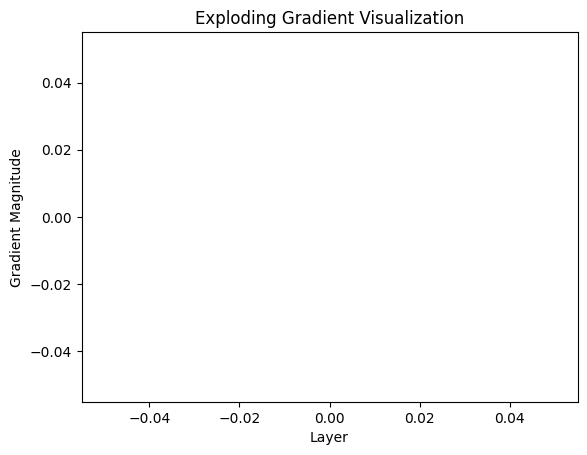

In [ ]:
plt.plot(gradients)
plt.xlabel('Layer')
plt.ylabel('Gradient Magnitude')
plt.title('Exploding Gradient Visualization')
plt.show()

## Simple Deep CNN Model 2 (Controlled Weight)
Let's see an example with controlled weight, each convolutional layer has its weights initialized to a constant value of 1.5.

In [ ]:
class DeepCNN(nn.Module):
    def __init__(self, num_layers):
        super(DeepCNN, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            layer = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
            # Adjust the weight initialization to a smaller value
            nn.init.constant_(layer.weight, 1.5)
            self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))  # Using ReLU activation
        return x

### Examine the Model

In [ ]:
model = DeepCNN(num_layers=15)  # Reduced the depth slightly
input_tensor = torch.randn(1, 1, 28, 28) * 0.5  # Reduced the magnitude of input values
output = model(input_tensor)
loss = F.mse_loss(output, torch.zeros_like(output))
print(f"Loss: {loss.item()}")  # Print the loss
model.zero_grad()
loss.backward()

Loss: 1.7856207913786334e+31


### Exploding Gradient Graph
Here we can see the exploding of gradient as we move from last layer to initial.

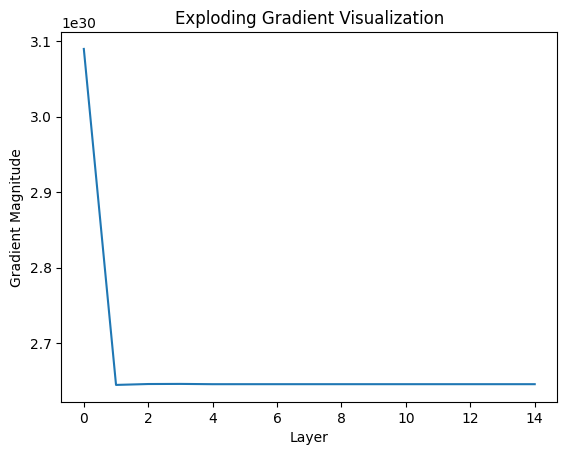

In [ ]:
gradients = []
for layer in model.layers:
    gradients.append(layer.weight.grad.abs().mean().item())

plt.plot(gradients)
plt.xlabel('Layer')
plt.ylabel('Gradient Magnitude')
plt.title('Exploding Gradient Visualization')
plt.show()

## Complex Deep CNN Model

Noe let'try with complex network,  ExplodingCNN is Deep CNN. The model starts with a single convolutional layer of 64 filters, followed by a ReLU activation.
18 additional convolutional layers are added. Each of these layers has its weights initialized with a normal distribution having a large standard deviation (1e2), which can lead to exploding gradients during training.

In [ ]:
class ExplodingCNN(nn.Module):
    def __init__(self):
        super(ExplodingCNN, self).__init__()

        # Convolutional layers with larger initialization
        layers = []
        layers.append(nn.Conv2d(1, 64, 3, padding=1))
        layers.append(nn.ReLU())

        for i in range(18):  # 18 additional conv layers
            conv_layer = nn.Conv2d(64, 64, 3, padding=1)
            nn.init.normal_(conv_layer.weight, mean=0, std=1e2)  # Initialize weights with larger values
            layers.append(conv_layer)
            layers.append(nn.ReLU())
            if i % 9 == 8:  # Pooling every 9 layers to ensure two poolings
                layers.append(nn.MaxPool2d(2, stride=2))

        self.convs = nn.Sequential(*layers)

        # Fully connected layer
        self.fc = nn.Linear(64 * 7 * 7, 10)  # Adjusted based on the feature map size after convolutions

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

### Dataset Preparation
Some random dataset

In [ ]:
# Random dataset
data = torch.randn(100, 1, 28, 28)  # 100 samples, 1 channel, 28x28 pixels
labels = torch.randint(0, 10, (100,))  # 100 random labels

model = ExplodingCNN()
optimizer = optim.SGD(model.parameters(), lr=1.0)  # Larger learning rate
criterion = nn.CrossEntropyLoss()

### Train the Model
Similar to above the model is trained and metrics are stored to plot the gradients.

In [ ]:
epoch_gradients = []
all_gradients = []
num_epochs = 50
layer_names = []

# Create a list to store loss values for each epoch
epoch_losses = []
epoch_accuracies = []

for name, param in model.named_parameters():
    layer_names.append(name)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

     # Record loss
    epoch_losses.append(loss.item())

    # Compute accuracy
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels)
    epoch_accuracies.append(accuracy)

    # Print loss and accuracy for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}, Accuracy: {accuracy:.6f}")

    # Store gradients every 10 epochs
    if epoch % 10 == 0:
        gradients = {}
        for name, param in model.named_parameters():
            if param.grad is not None:
                gradients[name] = param.grad.view(-1).norm().item()
        epoch_gradients.append(gradients)

    gradients_pe = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            gradients_pe[name] = param.grad.view(-1).norm().item()
    all_gradients.append(gradients_pe)

Epoch 1/50, Loss: nan, Accuracy: 0.110000
Epoch 2/50, Loss: nan, Accuracy: 0.110000
Epoch 3/50, Loss: nan, Accuracy: 0.110000
Epoch 4/50, Loss: nan, Accuracy: 0.110000
Epoch 5/50, Loss: nan, Accuracy: 0.110000
Epoch 6/50, Loss: nan, Accuracy: 0.110000
Epoch 7/50, Loss: nan, Accuracy: 0.110000
Epoch 8/50, Loss: nan, Accuracy: 0.110000
Epoch 9/50, Loss: nan, Accuracy: 0.110000
Epoch 10/50, Loss: nan, Accuracy: 0.110000
Epoch 11/50, Loss: nan, Accuracy: 0.110000
Epoch 12/50, Loss: nan, Accuracy: 0.110000
Epoch 13/50, Loss: nan, Accuracy: 0.110000
Epoch 14/50, Loss: nan, Accuracy: 0.110000
Epoch 15/50, Loss: nan, Accuracy: 0.110000
Epoch 16/50, Loss: nan, Accuracy: 0.110000
Epoch 17/50, Loss: nan, Accuracy: 0.110000
Epoch 18/50, Loss: nan, Accuracy: 0.110000
Epoch 19/50, Loss: nan, Accuracy: 0.110000
Epoch 20/50, Loss: nan, Accuracy: 0.110000
Epoch 21/50, Loss: nan, Accuracy: 0.110000
Epoch 22/50, Loss: nan, Accuracy: 0.110000
Epoch 23/50, Loss: nan, Accuracy: 0.110000
Epoch 24/50, Loss: n

### Exploding Gradient Graph
After plotting the graph there are no points in the graph representing the gradients have exploded.

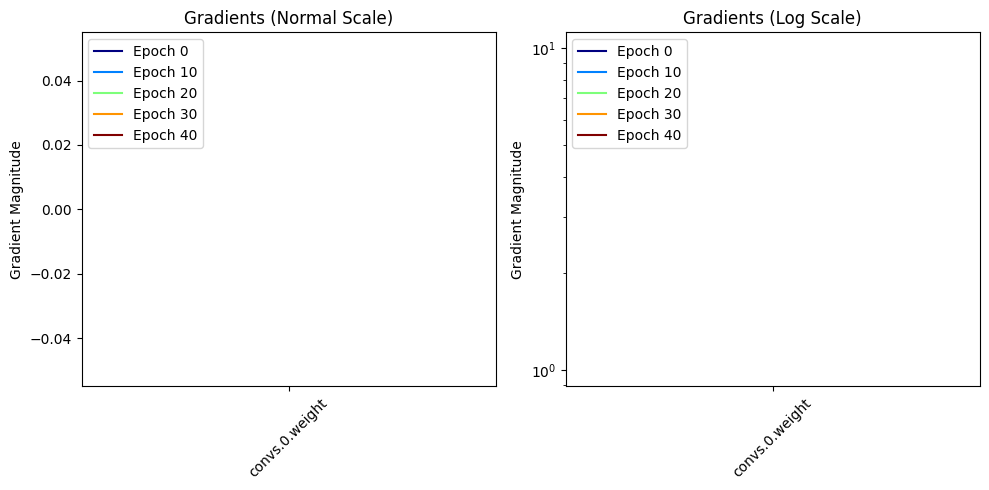

In [ ]:
# The key of the dictionary is the name of the parameter and the value is the gradient magnitude.

num_epochs = len(epoch_gradients)

# Create a colormap to have distinct colors for each epoch
colors = plt.cm.jet(np.linspace(0, 1, num_epochs))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # One row with 2 columns (Normal Scale and Log Scale)

for i, grads in enumerate(epoch_gradients):
    names = list(grads.keys())
    values = list(grads.values())

    # Normal Scale
    axes[0].plot(names, values, linestyle='-', color=colors[i], label=f"Epoch {i*10}")
    axes[0].set_title("Gradients (Normal Scale)")
    axes[0].set_ylabel("Gradient Magnitude")
    axes[0].tick_params(axis='x', rotation=45)

    # Log Scale
    axes[1].plot(names, values, linestyle='-', color=colors[i], label=f"Epoch {i*10}")
    axes[1].set_title("Gradients (Log Scale)")
    axes[1].set_ylabel("Gradient Magnitude")
    axes[1].set_yscale("log")
    axes[1].tick_params(axis='x', rotation=45)

axes[0].legend(loc="upper left")
axes[1].legend(loc="upper left")
plt.tight_layout()
plt.show()

Similarly the gradient has also exploded for avergare graph.

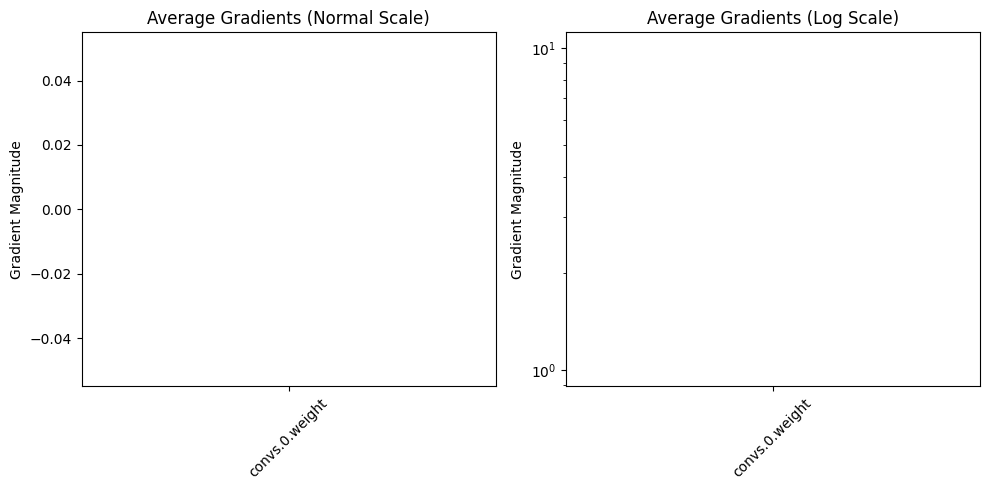

In [ ]:
# Initialize a dictionary to store the accumulated gradient magnitudes
avg_gradients = {name: 0 for name in all_gradients[0].keys()}

# Sum up the gradients over all epochs
for gradients in all_gradients:
    for name, value in gradients.items():
        avg_gradients[name] += value

# Divide by the number of epochs to get the average
for name in avg_gradients.keys():
    avg_gradients[name] /= num_epochs


# Extract parameter names and their corresponding average gradients
names = list(avg_gradients.keys())
values = list(avg_gradients.values())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # One row with 2 columns (Normal Scale and Log Scale)

# Normal Scale
axes[0].plot(names, values, linestyle='-', color='b')
axes[0].set_title("Average Gradients (Normal Scale)")
axes[0].set_ylabel("Gradient Magnitude")
axes[0].tick_params(axis='x', rotation=45)

# Log Scale
axes[1].plot(names, values, linestyle='-', color='b')
axes[1].set_title("Average Gradients (Log Scale)")
axes[1].set_ylabel("Gradient Magnitude")
axes[1].set_yscale("log")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Analysis:
The "nan" value in the loss indicates that, at some point during training, the computation resulted in a value that is not a number. This has induced the exploding gradient problem. To demonstrate this issue intentionall weights are initialised high value with high learning rate.

# Model without Residual Block

## Imports
Imports necessary libraries and modules to train a neural network on the MNIST dataset:

Torch Imports:

- torch: Main PyTorch library.
- torch.nn: Contains neural network layers, loss functions, and optimization algorithms.
- torch.optim: Contains optimization algorithms like SGD, Adam, etc.

Torchvision Imports:
- torchvision.transforms: Provides common image transformations.
- torchvision.models: Pre-defined neural network architectures (e.g., ResNet, VGG, etc.).
- MNIST: MNIST dataset module from torchvision.

Data Handling:
- DataLoader: A utility to load data in batches during training.
- random_split: Helps in splitting datasets into training, validation, or test sets.

Others:
- numpy: For numerical operations.
- matplotlib.pyplot: For plotting graphs and visualizations.
- classification_report, confusion_matrix: From sklearn.metrics to evaluate model performance.
- seaborn: A statistical data visualization library, often used for heatmaps like confusion matrices.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torchvision.datasets import ImageFolder

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Dataset
It loads the MNIST dataset, which contains images of handwritten digits, and applies several preprocessing steps before dividing the data into training, validation, and test sets.

A transformation pipeline is defined using transforms.
- Images are resized to 32x32.
- They are converted into tensors.
- Since MNIST images are grayscale, they are repeated across three channels to simulate RGB images.
- The images are normalized to have values between [-1, 1] for each channel.

After defining the transformations, the MNIST dataset is loaded both for training and testing. The training set is further split into a main training set and a validation set. Data loaders are created to handle batching and shuffling of these datasets for the training process.

In [ ]:
# Load the MNIST dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert to tensor
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert grayscale to RGB
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

In [ ]:
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)
# Split the training data into train and validation sets
train_data, val_data = random_split(mnist_train, [len(mnist_train) - 5000, 5000])
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 413816313.93it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111133664.06it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 79341617.11it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 23842964.67it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Non Residual Block and Non Residual ResNet50
The code is designed to create a deep convolutional neural network inspired by the ResNet50 architecture but without its signature residual connections.

- **NonResidualBottleneck**:
  This module defines a building block of the architecture. It follows a pattern: a 1x1 convolution, a 3x3 convolution, and another 1x1 convolution, each followed by batch normalization and ReLU activation. These sets of layers are a part of the "bottleneck" design which is a hallmark of ResNet architectures, primarily to reduce and then expand dimensions.

- **NonResidualResNet50**:
  This module assembles the entire architecture. The network starts with an initial convolution and max-pooling, followed by four sets of bottleneck blocks (each set having a different number of blocks and channels).

  The `_make_layer` function is a utility to create a sequence of bottleneck blocks for a given number of blocks, channels, and strides.

- Finally, a model is instantiated, and the necessary loss function (cross-entropy) and optimizer (Adam) are defined.

This version of ResNet50 lacks the "skip connections" or "residual connections" that the original ResNet50 architecture includes. This makes it an interesting experiment to see how the absence of these connections affects training and performance.

In [ ]:
class NonResidualBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(NonResidualBottleneck, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride,
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels *
                      NonResidualBottleneck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * NonResidualBottleneck.expansion),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class NonResidualResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super(NonResidualResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(NonResidualBottleneck, 64, 3)
        self.layer2 = self._make_layer(NonResidualBottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(NonResidualBottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(NonResidualBottleneck, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * NonResidualBottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Create the ResNet50 model
resnet_model = NonResidualResNet50().to(device)
# Define the loss function, optimizer, and metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters())

  Several lists are created to store the loss and accuracy values of the training and validation sets for plotting later. Furthermore, dictionaries are initialized to store gradient information for each trainable parameter (ignoring biases) in the model.


In [ ]:
# Lists to store loss and accuracy values for plotting
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []
# Initialize
gradient_per_epoch = {name: [] for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}
overall_gradient_sum = {name: 0 for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}
overall_gradient_count = {name: 0 for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}
layers_order = [name for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name]


## Train the model
- **Training Loop**:
  The model is trained for 5 epochs. Within each epoch, the model undergoes both training and validation phases.

  - **Training Phase**:
    The model is set to training mode using `resnet_model.train()`. For each batch of data from `train_loader`, the model's parameters are updated. The gradients of the parameters are also accumulated for analysis. The training loss and accuracy are computed and stored.


  - **Validation Phase**:
    The model is set to evaluation mode using `resnet_model.eval()`. For each batch of data from `val_loader`, the model's performance is evaluated without updating its parameters. The validation loss and accuracy are computed and stored.


  - **Gradient Analysis**:
    For each epoch, the average gradient magnitude for each parameter is computed and stored. This is useful to analyze the vanishing and exploding gradient phenomena. The overall gradient sums and counts are also accumulated.


- **Output**:
  After each epoch, the training and validation loss and accuracy values are printed to monitor the model's performance.

Basically, this code block trains the model for a specified number of epochs and monitors its performance using loss and accuracy metrics. It also keeps track of gradient magnitudes to analyze the model's behavior during training.

In [ ]:
# Train the model
for epoch in range(5):
    # Training
    resnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    # Gradient stats initialization for this epoch
    gradient_stats = {name: 0 for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}
    gradient_count = {name: 0 for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}


    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient accumulation
        for name, param in resnet_model.named_parameters():
            if param.requires_grad and "bias" not in name:
                grad = param.grad.clone().detach().cpu()  # Move gradient to CPU
                gradient_stats[name] += grad.abs().sum().item()
                gradient_count[name] += grad.numel()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy = correct_train / total_train

    # Validation
    resnet_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = resnet_model(inputs)
            loss = criterion(val_outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(val_outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = correct_val / total_val

    # Append values to lists for plotting
    train_losses.append(running_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    # Store gradients for this epoch
    for name in gradient_per_epoch:
        gradient_per_epoch[name].append(gradient_stats[name] / gradient_count[name])
        overall_gradient_sum[name] += gradient_stats[name]
        overall_gradient_count[name] += gradient_count[name]


    print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {val_accuracy}")

Epoch 1, Train Loss: 1.372719455735628, Train Accuracy: 0.4724909090909091, Val Loss: 1.69030721783638, Val Accuracy: 0.5278
Epoch 2, Train Loss: 1.2262216414130012, Train Accuracy: 0.5395454545454546, Val Loss: 0.9520924046635628, Val Accuracy: 0.652
Epoch 3, Train Loss: 1.0482144763303358, Train Accuracy: 0.6441818181818182, Val Loss: 3.1038824200630186, Val Accuracy: 0.2582
Epoch 4, Train Loss: 0.9767045526310455, Train Accuracy: 0.688509090909091, Val Loss: 2.01300810277462, Val Accuracy: 0.2884
Epoch 5, Train Loss: 1.2942250024440676, Train Accuracy: 0.5582363636363636, Val Loss: 1.4854929059743882, Val Accuracy: 0.4298


## Visualise Gradient Graph
Graphs for visualisation
1. **Average Gradient Computation**:
   The average gradient magnitude for each layer over all the epochs is computed.

2. **Gradient Per Epoch (Regular Scale)**:
   A plot is generated showing the gradient magnitudes for each layer at each epoch on a regular scale. Different colors represent different epochs.

3. **Gradient Per Epoch (Log Scale)**:
   Similar to the previous plot, but the y-axis is in logarithmic scale, aiding in viewing smaller gradient values that might be difficult to spot on a regular scale.

4. **Average Gradient (Regular Scale)**:
   A plot displays the average gradient magnitude of each layer over all epochs on a regular scale.

5. **Average Gradient (Log Scale)**:
   This is similar to the previous plot but visualized on a logarithmic scale for the y-axis.

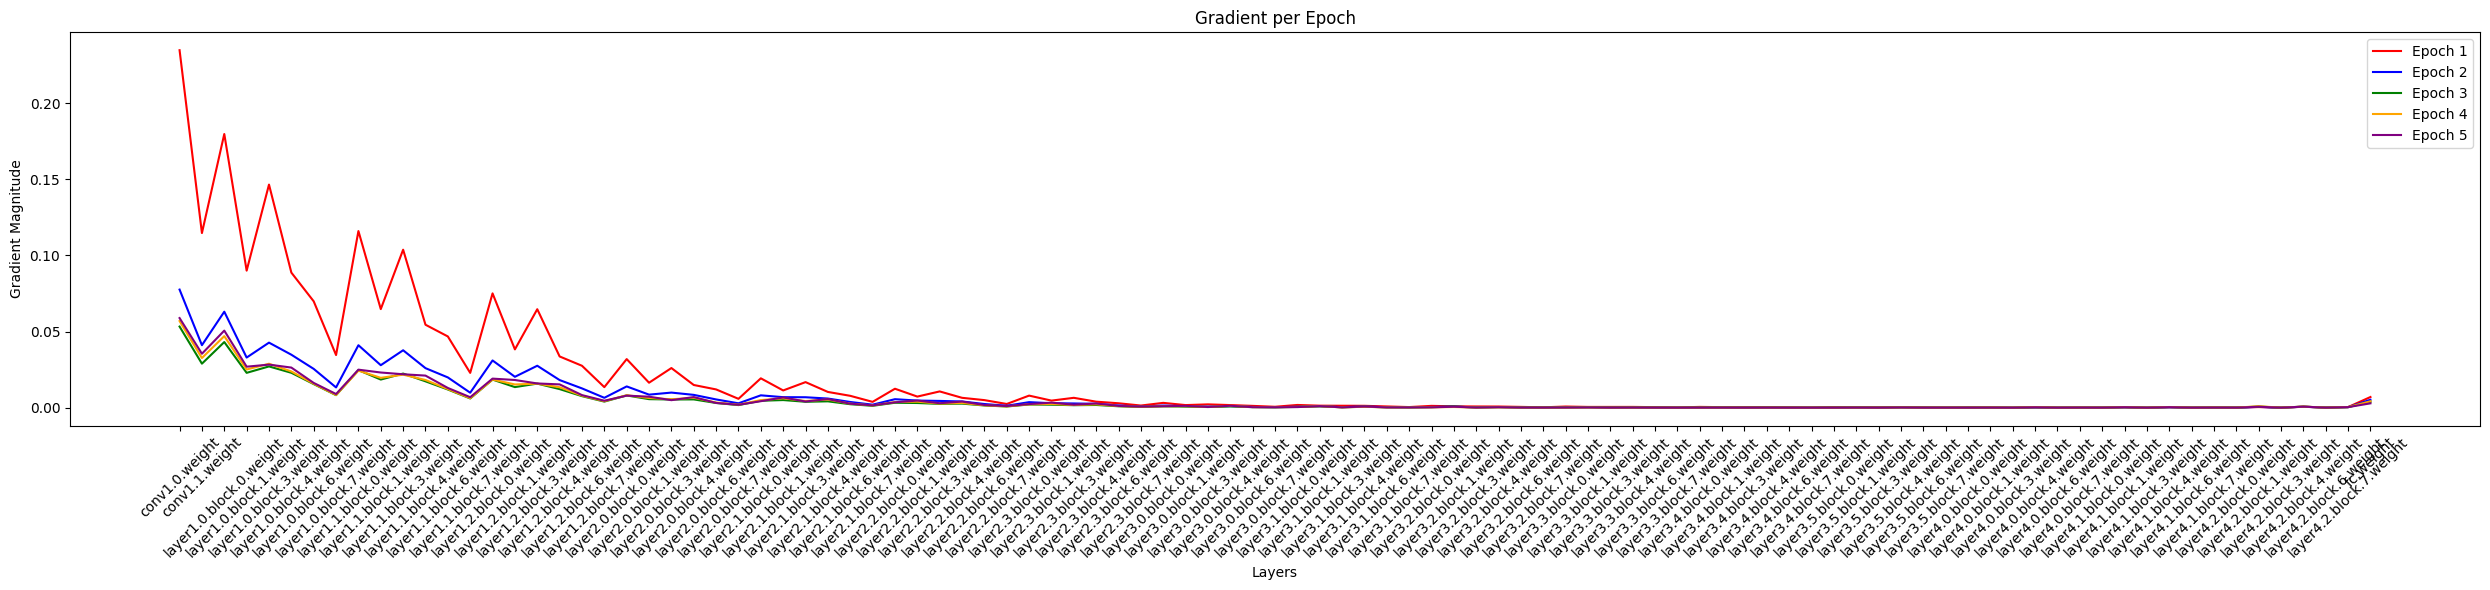

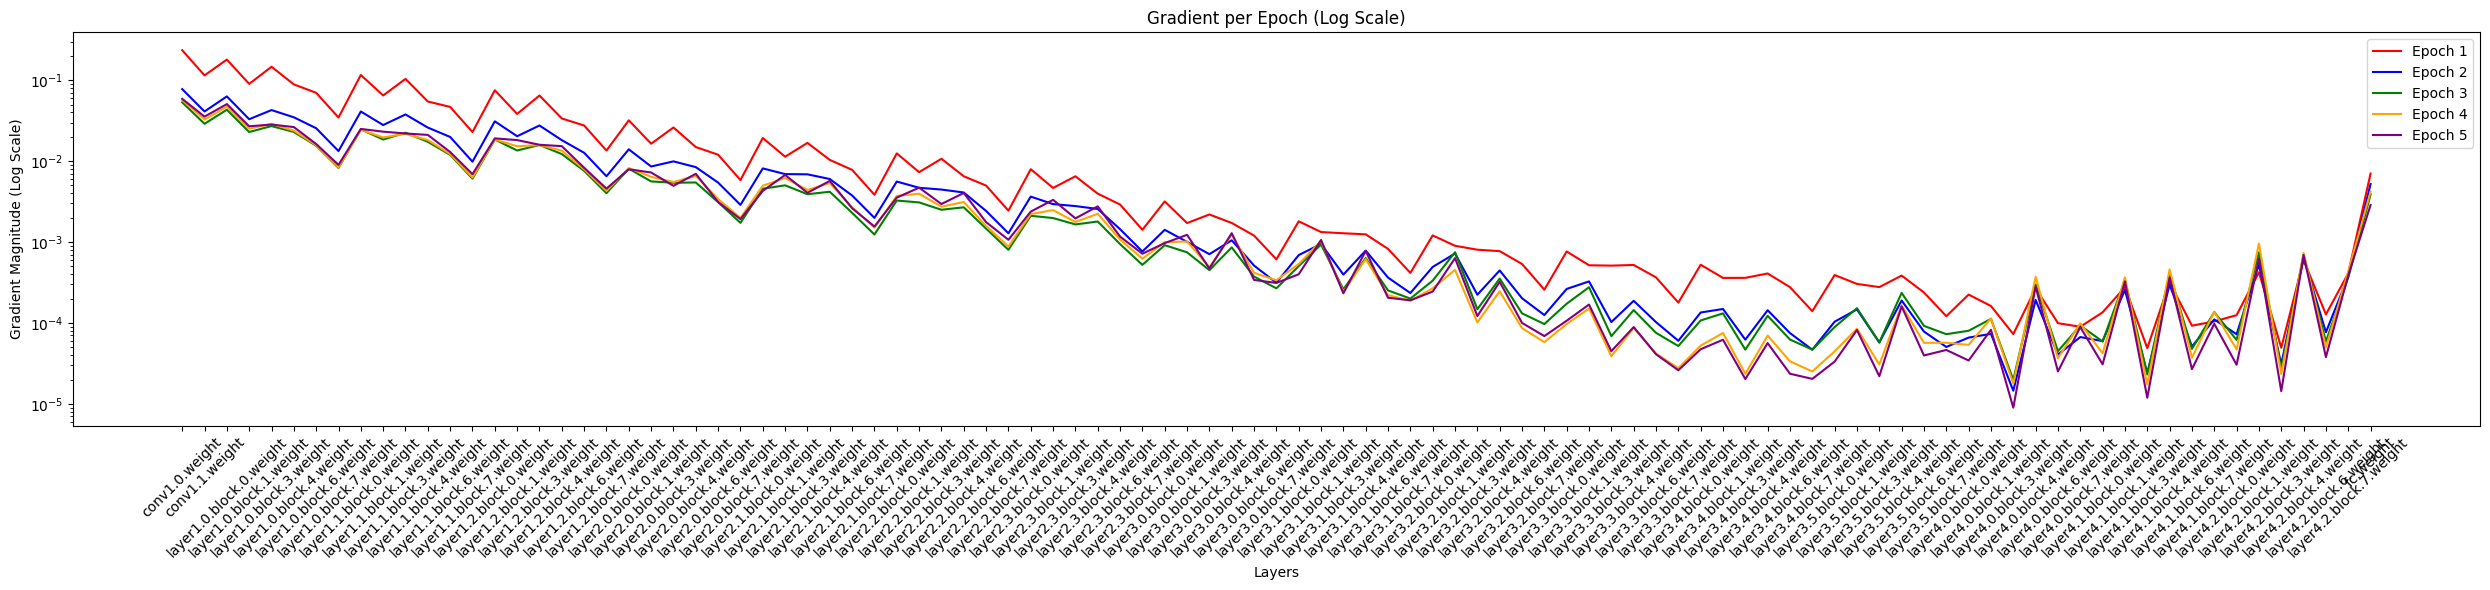

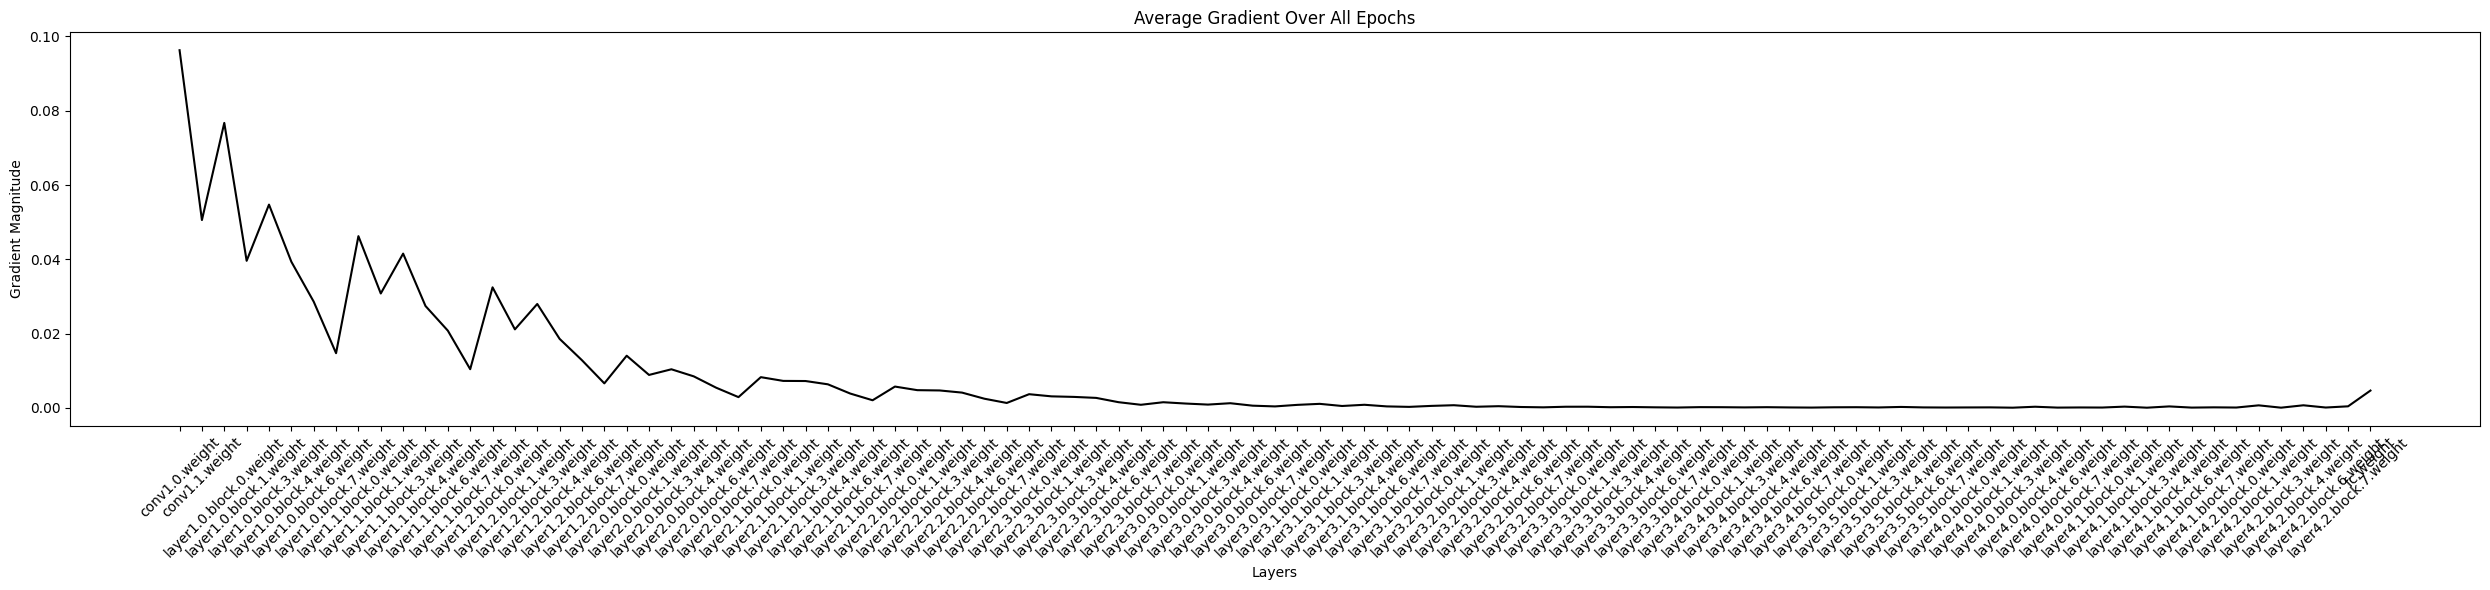

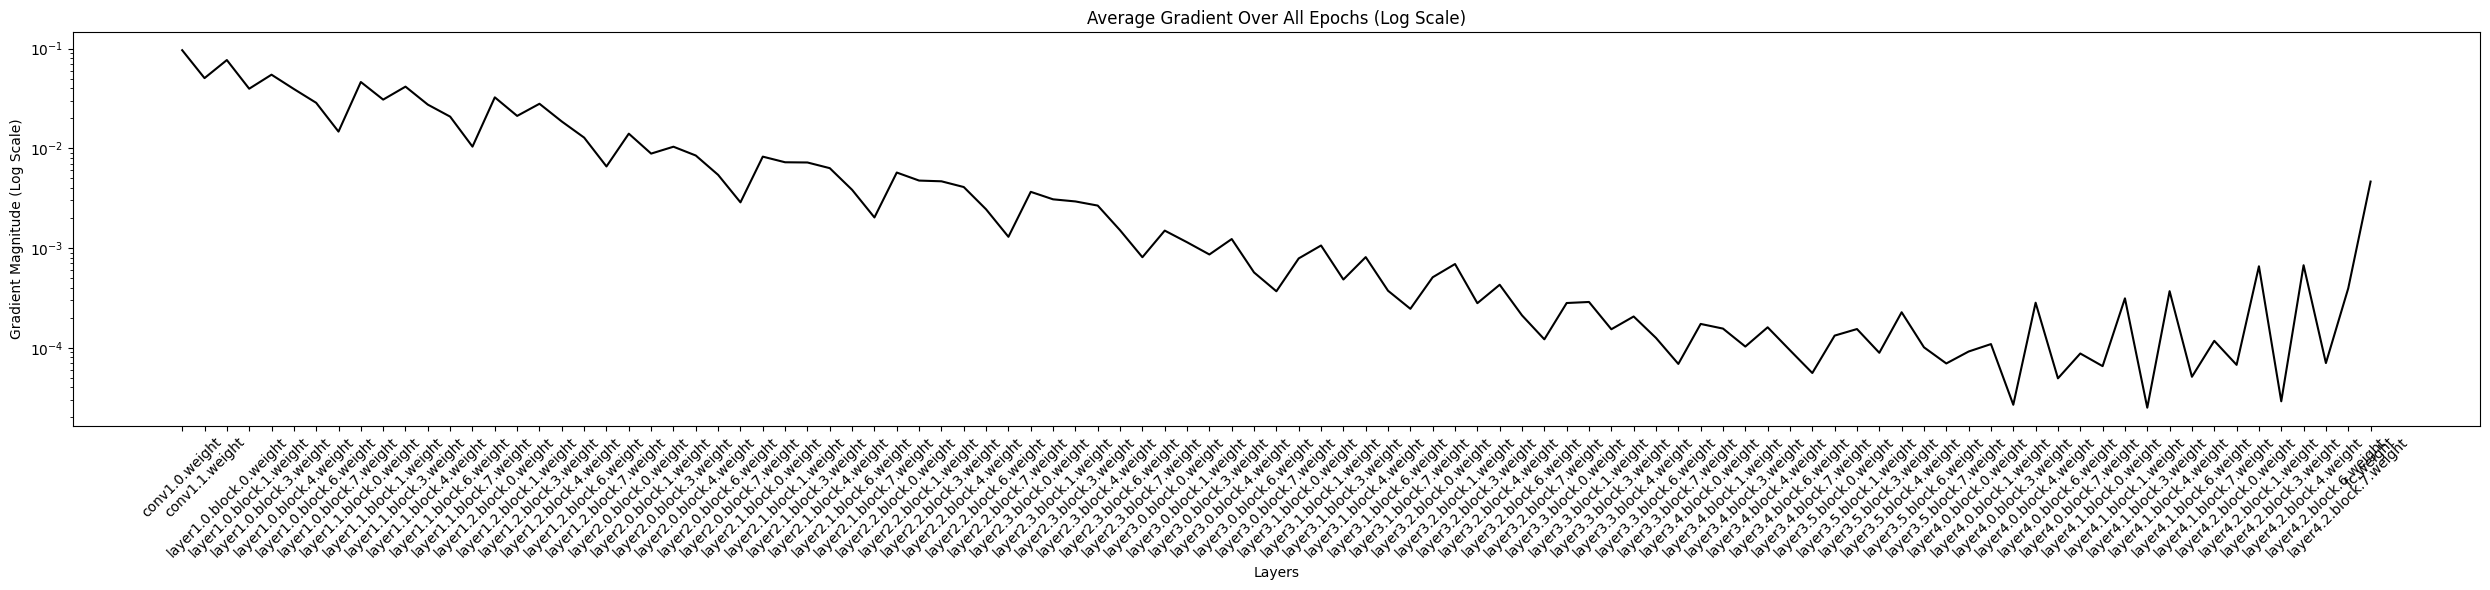

In [ ]:
# Compute average gradients over all epochs
average_gradients = {name: overall_gradient_sum[name] / overall_gradient_count[name] for name in gradient_per_epoch}

# Gradient per epoch on regular scale
fig, ax = plt.subplots(figsize=(25, 6))
for epoch, color in zip(range(5), ['red', 'blue', 'green', 'orange', 'purple']):
    gradients = [gradient_per_epoch[name][epoch] for name in layers_order]
    ax.plot(layers_order, gradients, label=f'Epoch {epoch + 1}', color=color)
ax.set_xlabel("Layers")
ax.set_ylabel("Gradient Magnitude")
ax.set_title("Gradient per Epoch")
ax.legend()
ax.set_xticks(layers_order)
ax.set_xticklabels(layers_order, rotation=45)
plt.tight_layout()
plt.show()

# Gradient per epoch on log scale
fig, ax = plt.subplots(figsize=(25, 6))
for epoch, color in zip(range(5), ['red', 'blue', 'green', 'orange', 'purple']):
    gradients = [gradient_per_epoch[name][epoch] for name in layers_order]
    ax.plot(layers_order, gradients, label=f'Epoch {epoch + 1}', color=color)
ax.set_yscale("log")
ax.set_xlabel("Layers")
ax.set_ylabel("Gradient Magnitude (Log Scale)")
ax.set_title("Gradient per Epoch (Log Scale)")
ax.legend()
ax.set_xticks(layers_order)
ax.set_xticklabels(layers_order, rotation=45)
plt.tight_layout()
plt.show()

# Average gradient on regular scale
fig, ax = plt.subplots(figsize=(25, 6))
avg_grads = [average_gradients[name] for name in layers_order]
ax.plot(layers_order, avg_grads, color='black')
ax.set_xlabel("Layers")
ax.set_ylabel("Gradient Magnitude")
ax.set_title("Average Gradient Over All Epochs")
ax.set_xticks(layers_order)
ax.set_xticklabels(layers_order, rotation=45)
plt.tight_layout()
plt.show()

# Average gradient on log scale
fig, ax = plt.subplots(figsize=(25, 6))
avg_grads = [average_gradients[name] for name in layers_order]
ax.plot(layers_order, avg_grads, color='black')
ax.set_yscale("log")
ax.set_xlabel("Layers")
ax.set_ylabel("Gradient Magnitude (Log Scale)")
ax.set_title("Average Gradient Over All Epochs (Log Scale)")
ax.set_xticks(layers_order)
ax.set_xticklabels(layers_order, rotation=45)
plt.tight_layout()
plt.show()


Analysis:

Gradient Magnitude Declines Over Epochs: The magnitude of the gradients seems to decline from Epoch 1 to Epoch 5. This indicates that the model is settling into an optimization landscape. As the model learns, we typically expect the magnitude of the gradients to decrease because the model is approaching a local minimum.

High Initial Gradients: The initial gradient magnitude (Epoch 1) is quite high for the earlier layers, especially for "conv1.0.weight". Such high gradients might be indicative of an exploding gradient problem, especially if these large gradient values propagate throughout the network. However, they decline rapidly in the next epochs.

Stable Gradients in Later Layers: The gradients for the layers towards the end of the x-axis (representing deeper layers of the network) are relatively stable and low. This suggests that these layers might not be learning much or are learning at a much slower pace.

Slight Increase in Epoch 5: While overall the gradient magnitude seems to decline over epochs, there is a slight increase or stabilization of gradient magnitudes in Epoch 5 for some layers. This can be a point of interest, and you might want to monitor if this trend continues in further epochs.

## Visualise  Acc/Loss Graph
Training and Validation Accuracy and Loss Graph

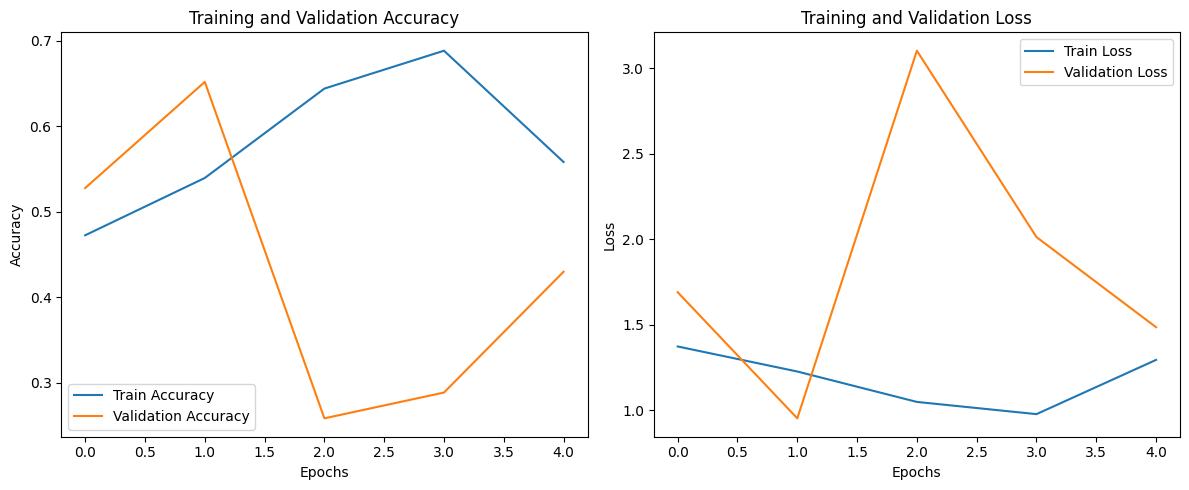

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Analysis:
Accuracy Trends: Training accuracy consistently rises over epochs, indicating the model is learning. However, validation accuracy peaks around the 2.5th epoch and then decreases.

Loss Trends: Training loss steadily decreases, suggesting better fits to training data. Validation loss decreases until around the 2.5th epoch, then sharply rises.

## Test Model
Evaluating the performance of the trained resnet_model on the test dataset. It loads each batch of test data, feeds it to the model, and computes the loss and accuracy. At the end, it prints the overall test loss and test accuracy to give an indication of the model's performance on unseen data.

In [ ]:
# Test the model
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy = correct_test / total_test
test_losses.append(test_loss/len(test_loader))
test_accuracies.append(test_accuracy)

print(f"Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {test_accuracy}")

Test Loss: 1.4464880288401736, Test Accuracy: 0.4508


## Prediction

In [ ]:
# Get all predictions and true labels from the test set
all_predictions = []
all_true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

## Classification Report

In [ ]:
# Generate the classification report
report = classification_report(all_true_labels, all_predictions, target_names=[str(i) for i in range(10)])
print(report)

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       980
           1       0.62      0.91      0.74      1135
           2       0.29      0.02      0.03      1032
           3       0.47      0.48      0.48      1010
           4       0.38      0.92      0.54       982
           5       0.35      0.31      0.33       892
           6       0.82      0.36      0.50       958
           7       0.30      0.50      0.38      1028
           8       0.00      0.00      0.00       974
           9       0.11      0.12      0.12      1009

    accuracy                           0.45     10000
   macro avg       0.43      0.44      0.40     10000
weighted avg       0.43      0.45      0.40     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrix

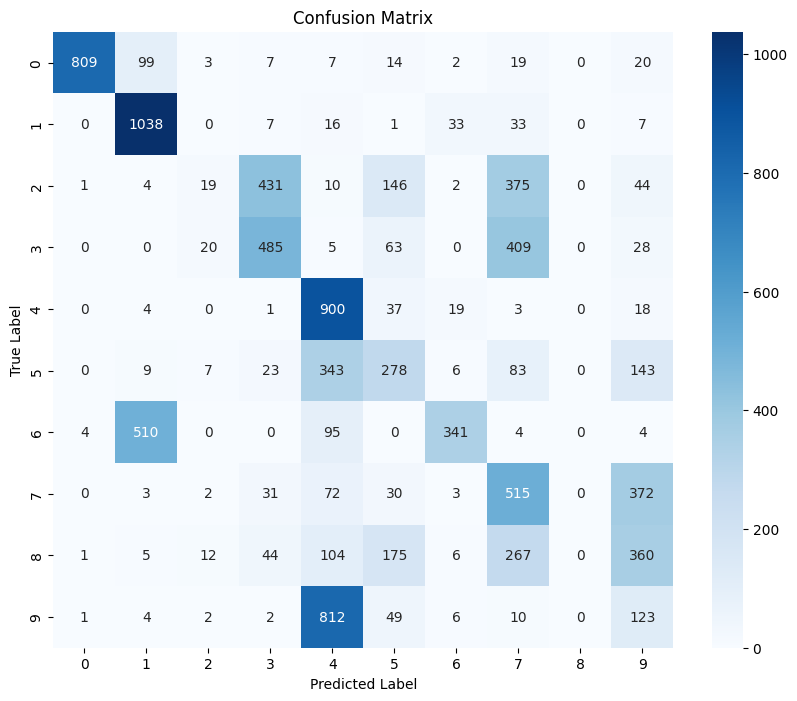

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Accuracy of test model was only 0.4508. So most of the time the label are being predicted as wrong.

## Random Samples

In [ ]:
# Randomly select 5 samples from the test data
random_indices = np.random.choice(len(mnist_test), 5, replace=False)
random_data_samples = [mnist_test[i][0] for i in random_indices]
random_label_samples = [mnist_test[i][1] for i in random_indices]

# Convert samples to DataLoader for batch processing
sample_loader = DataLoader(list(zip(random_data_samples, random_label_samples)), batch_size=5, shuffle=False)


In [ ]:
# Predict labels for the randomly selected samples
with torch.no_grad():
    for inputs, labels in sample_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        random_predictions = resnet_model(inputs)


In [ ]:
# Display the predictions alongside the actual labels
for i, (pred, actual) in enumerate(zip(random_predictions, labels)):
    print(f"Sample {i+1}: Predicted: {torch.argmax(pred).item()}, Actual: {actual.item()}")

Sample 1: Predicted: 6, Actual: 6
Sample 2: Predicted: 7, Actual: 2
Sample 3: Predicted: 3, Actual: 3
Sample 4: Predicted: 9, Actual: 7
Sample 5: Predicted: 7, Actual: 2


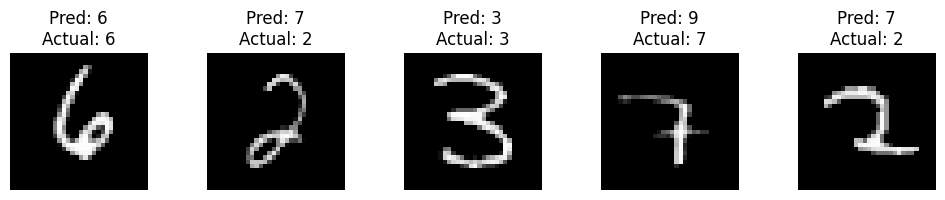

In [ ]:
# Display the images, predicted labels, and actual labels
plt.figure(figsize=(10, 2))
for i, (image, pred, actual) in enumerate(zip(random_data_samples, random_predictions, labels)):
    plt.subplot(1, 5, i+1)
    plt.imshow(image.cpu().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')  # Convert tensor to numpy for visualization
    plt.title(f"Pred: {torch.argmax(pred).item()}\nActual: {actual.item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Model with Residual Block
A deep learning architecture for the ResNet-50 model, a widely-used model for image classification tasks but from scratch.

Bottleneck Class:

- expansion: This factor determines how much we should expand the channels after passing through the bottleneck.
residual_function: This is the core of the bottleneck, which is a sequence of - - convolutional layers. The bottleneck structure reduces the number of channels, processes the data, and then expands the channels back. This helps in reducing the computation while not compromising on capacity.
- shortcut: It's a direct path from the input to the output of the bottleneck block. If the input and output dimensions of the block are different, this path will include a convolution layer to change the input dimensions to match the output.
- forward: Combines the residual function and the shortcut, and applies the ReLU activation function. This is the essential part of the ResNet's "residual learning" which helps the model to learn residual (or difference) between input and output, easing the training process.

ResNet50 Class:
- conv1: Initial convolutional layer that processes the input image.
- maxpool: Max pooling layer reduces the spatial dimensions.
- layer1, layer2, layer3, layer4: These are the main blocks of the ResNet50 model. Each block contains multiple bottleneck layers. The number of layers in each block, and the number of channels processed, differ.
- avgpool: An adaptive average pooling layer which reduces the spatial dimensions to 1x1, making it easier to flatten and pass to the fully connected layer.
- fc: The final fully connected layer which outputs class probabilities.
- _make_layer: A helper function to create blocks of bottleneck layers. It ensures the right number of channels and applies the correct stride, ensuring spatial dimensions are reduced appropriately.

Finally, an instance of the ResNet50 model is created and transferred to the appropriate device (CPU/GPU). The code also sets up a cross-entropy loss function for classification and uses the Adam optimizer to train the model.

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride,
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels *
                      Bottleneck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * Bottleneck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * Bottleneck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * Bottleneck.expansion,
                          stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * Bottleneck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class ResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(Bottleneck, 64, 3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Create the ResNet50 model
resnet_model = ResNet50().to(device)
# Define the loss function, optimizer, and metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters())

Same process is repeated as above.

In [ ]:
# Lists to store loss and accuracy values for plotting
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []
# Initialize
gradient_per_epoch = {name: [] for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}
overall_gradient_sum = {name: 0 for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}
overall_gradient_count = {name: 0 for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}
layers_order = [name for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name]

## Train Model

In [ ]:
# Train the model
for epoch in range(5):
    # Training
    resnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    # Gradient stats initialization for this epoch
    gradient_stats = {name: 0 for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}
    gradient_count = {name: 0 for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient accumulation
        for name, param in resnet_model.named_parameters():
            if param.requires_grad and "bias" not in name:
                grad = param.grad.clone().detach().cpu()  # Move gradient to CPU
                gradient_stats[name] += grad.abs().sum().item()
                gradient_count[name] += grad.numel()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy = correct_train / total_train

    # Validation
    resnet_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = resnet_model(inputs)
            loss = criterion(val_outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(val_outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = correct_val / total_val

    # Append values to lists for plotting
    train_losses.append(running_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    # Store gradients for this epoch
    for name in gradient_per_epoch:
        gradient_per_epoch[name].append(gradient_stats[name] / gradient_count[name])
        overall_gradient_sum[name] += gradient_stats[name]
        overall_gradient_count[name] += gradient_count[name]

    print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {val_accuracy}")

Epoch 1, Train Loss: 0.20136831844831968, Train Accuracy: 0.9402545454545455, Val Loss: 0.07926059351302683, Val Accuracy: 0.9784
Epoch 2, Train Loss: 0.06349238336172908, Train Accuracy: 0.9813272727272727, Val Loss: 0.08258770315442235, Val Accuracy: 0.975
Epoch 3, Train Loss: 0.04437146695367288, Train Accuracy: 0.9872181818181818, Val Loss: 0.05316846297355369, Val Accuracy: 0.9874
Epoch 4, Train Loss: 0.038919391753260306, Train Accuracy: 0.9885636363636363, Val Loss: 0.05102962238015607, Val Accuracy: 0.987
Epoch 5, Train Loss: 0.037291241188392825, Train Accuracy: 0.9892909090909091, Val Loss: 0.07346543838793877, Val Accuracy: 0.9818


## Visualise Gradient Graph

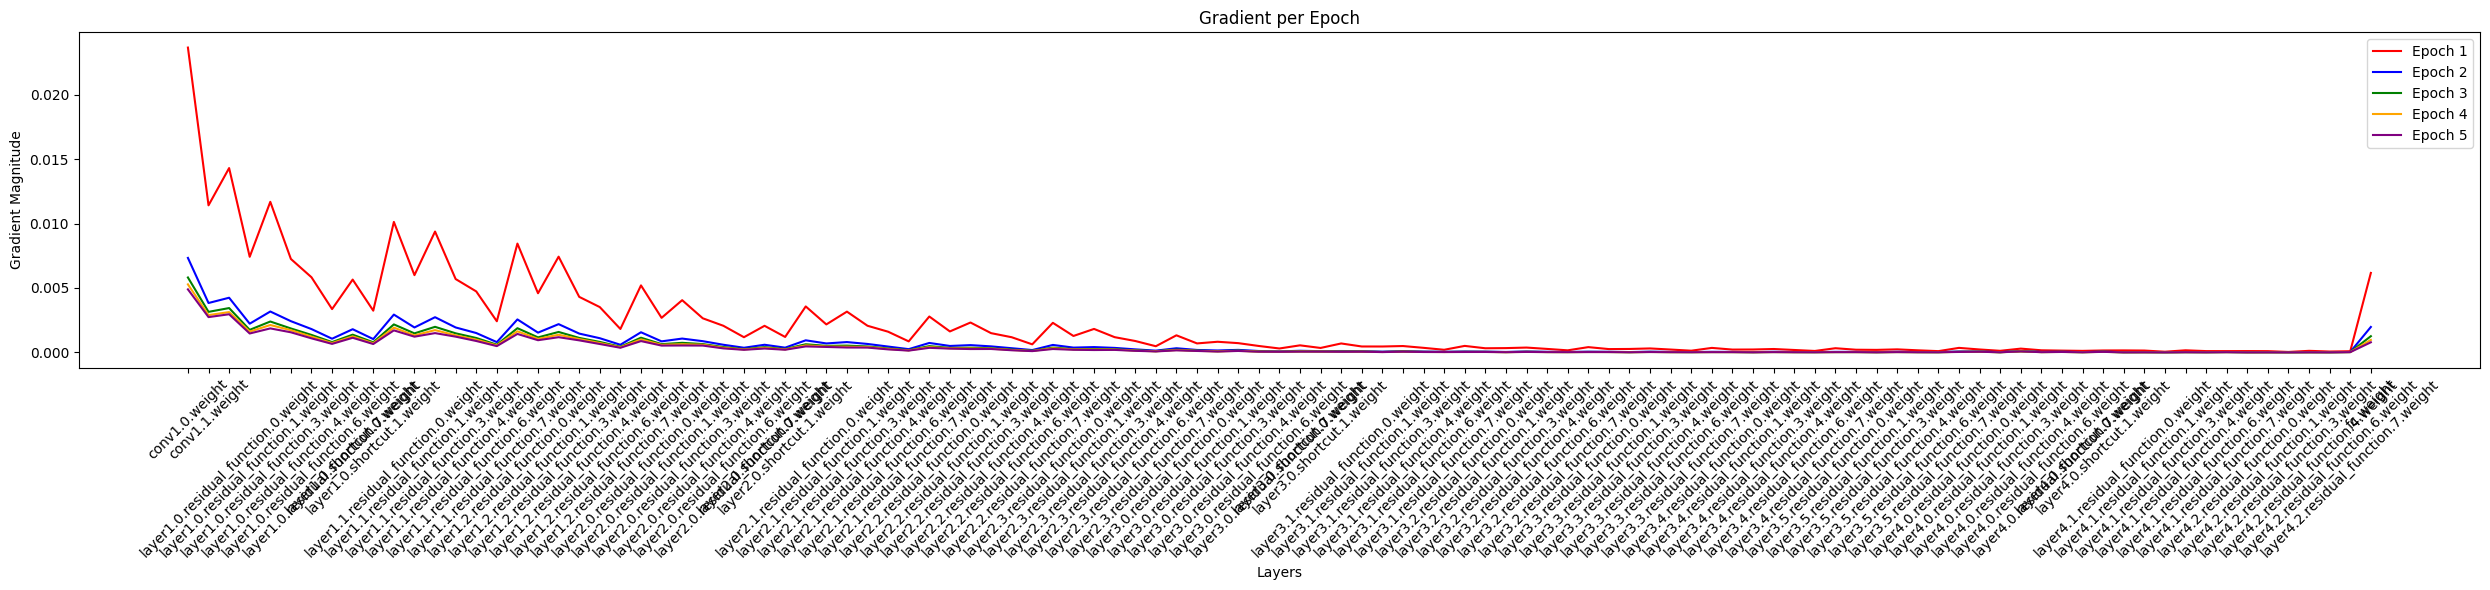

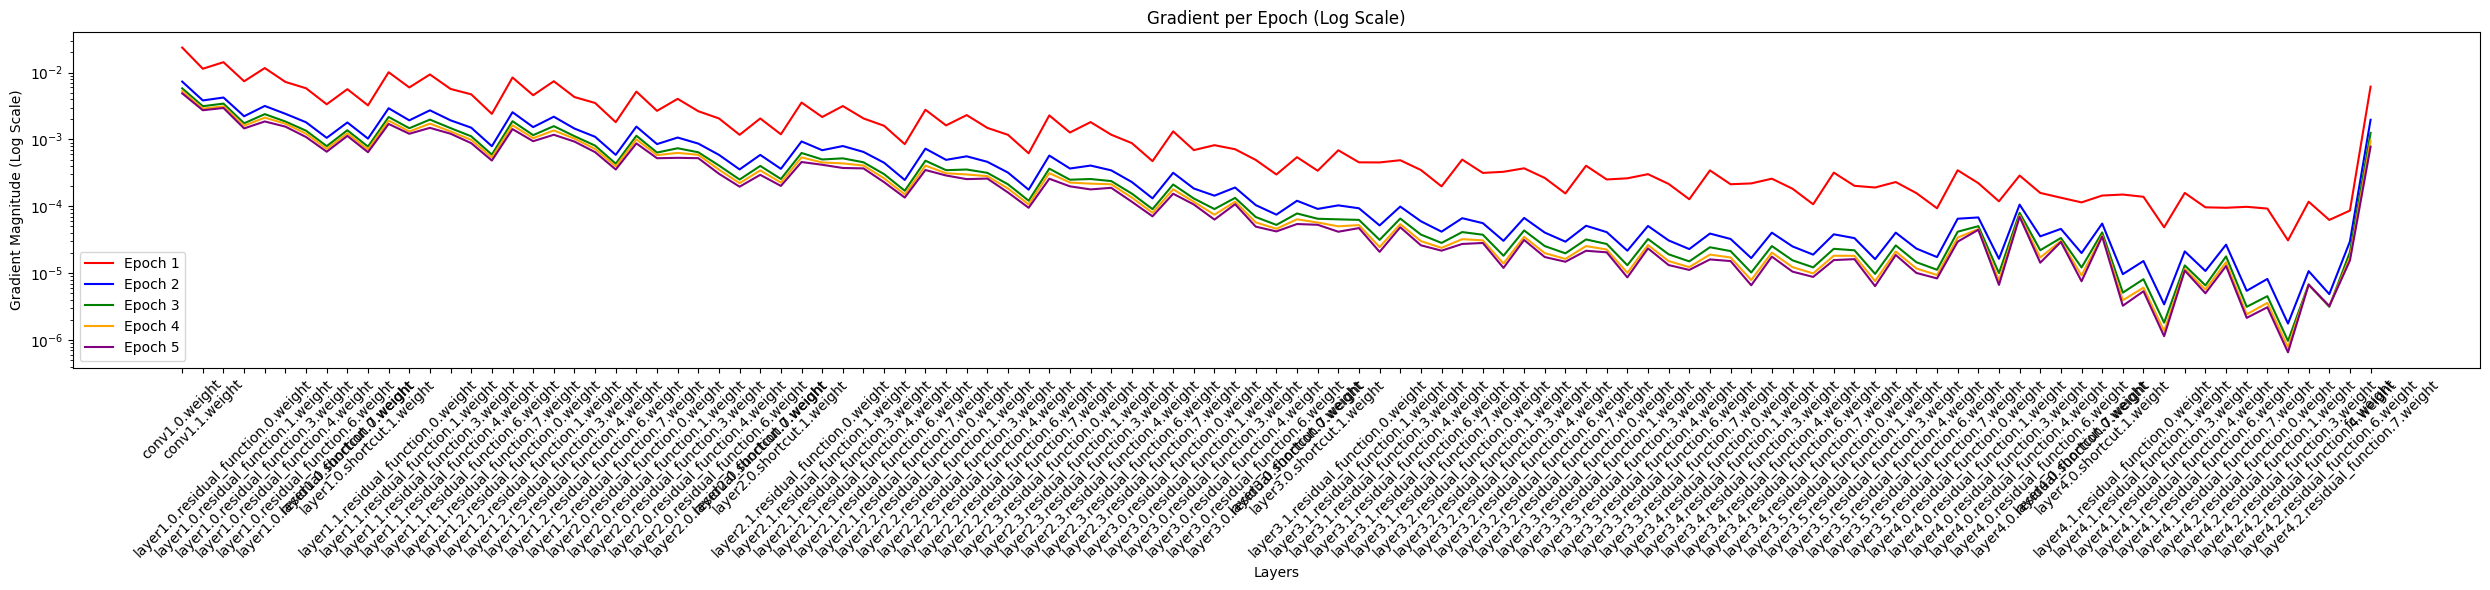

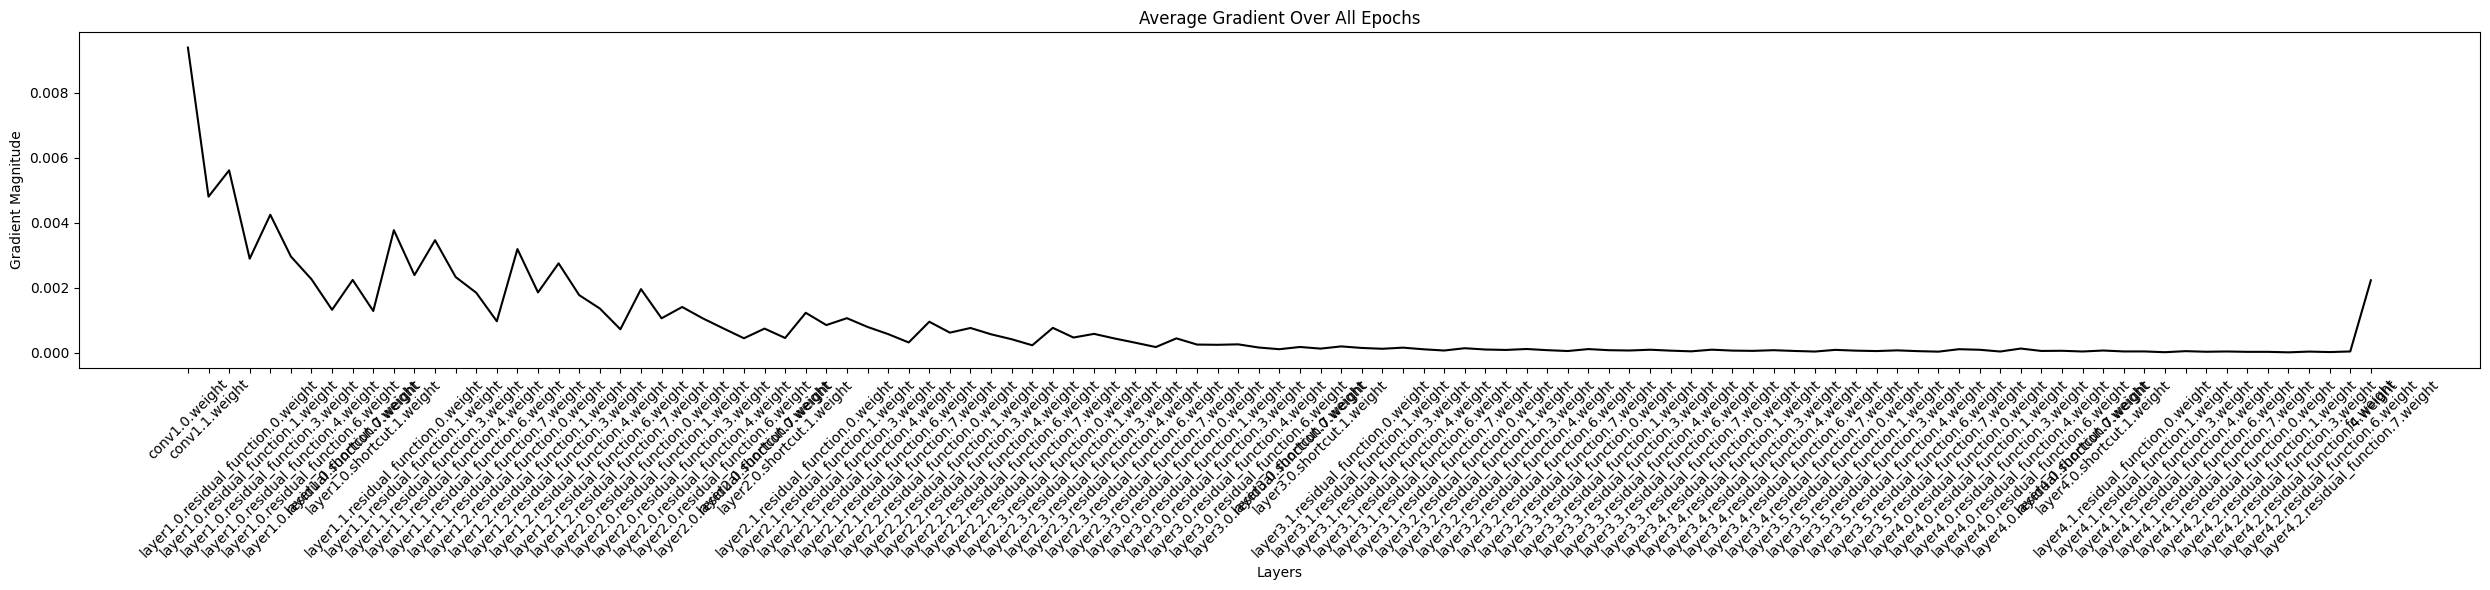

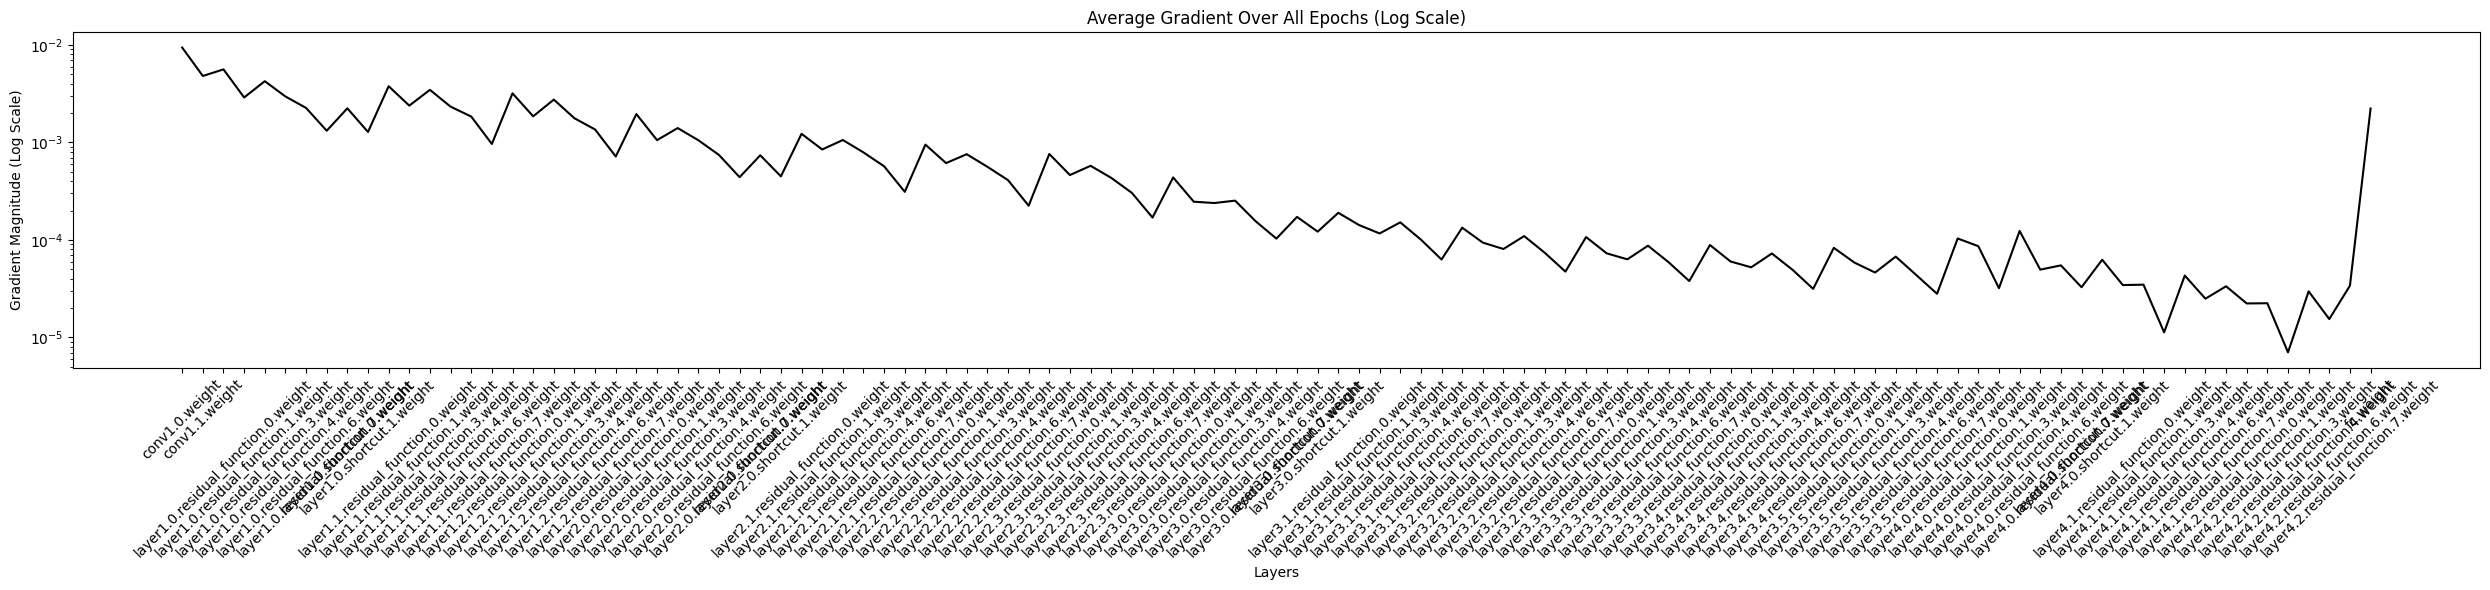

In [ ]:
# Compute average gradients over all epochs
average_gradients = {name: overall_gradient_sum[name] / overall_gradient_count[name] for name in gradient_per_epoch}

# Gradient per epoch on regular scale
fig, ax = plt.subplots(figsize=(25, 6))
for epoch, color in zip(range(5), ['red', 'blue', 'green', 'orange', 'purple']):
    gradients = [gradient_per_epoch[name][epoch] for name in layers_order]
    ax.plot(layers_order, gradients, label=f'Epoch {epoch + 1}', color=color)
ax.set_xlabel("Layers")
ax.set_ylabel("Gradient Magnitude")
ax.set_title("Gradient per Epoch")
ax.legend()
ax.set_xticks(layers_order)
ax.set_xticklabels(layers_order, rotation=45)
plt.tight_layout()
plt.show()

# Gradient per epoch on log scale
fig, ax = plt.subplots(figsize=(25, 6))
for epoch, color in zip(range(5), ['red', 'blue', 'green', 'orange', 'purple']):
    gradients = [gradient_per_epoch[name][epoch] for name in layers_order]
    ax.plot(layers_order, gradients, label=f'Epoch {epoch + 1}', color=color)
ax.set_yscale("log")
ax.set_xlabel("Layers")
ax.set_ylabel("Gradient Magnitude (Log Scale)")
ax.set_title("Gradient per Epoch (Log Scale)")
ax.legend()
ax.set_xticks(layers_order)
ax.set_xticklabels(layers_order, rotation=45)
plt.tight_layout()
plt.show()

# Average gradient on regular scale
fig, ax = plt.subplots(figsize=(25, 6))
avg_grads = [average_gradients[name] for name in layers_order]
ax.plot(layers_order, avg_grads, color='black')
ax.set_xlabel("Layers")
ax.set_ylabel("Gradient Magnitude")
ax.set_title("Average Gradient Over All Epochs")
ax.set_xticks(layers_order)
ax.set_xticklabels(layers_order, rotation=45)
plt.tight_layout()
plt.show()

# Average gradient on log scale
fig, ax = plt.subplots(figsize=(25, 6))
avg_grads = [average_gradients[name] for name in layers_order]
ax.plot(layers_order, avg_grads, color='black')
ax.set_yscale("log")
ax.set_xlabel("Layers")
ax.set_ylabel("Gradient Magnitude (Log Scale)")
ax.set_title("Average Gradient Over All Epochs (Log Scale)")
ax.set_xticks(layers_order)
ax.set_xticklabels(layers_order, rotation=45)
plt.tight_layout()
plt.show()


Gradient Magnitude Trends: Across all epochs, gradients appear to be highest for earlier layers, especially in the Conv1.0.Weight and Conv1.1.Weight sections. This suggests these layers experience the most adjustments during training.

Stabilization Over Epochs: As epochs progress, the magnitude of the gradients tends to decrease, indicating a stabilization of the weights as training progresses.

It means no problem with gradient, which can be verified with accuracy as well.

## Visualise Acc/Loss Graph

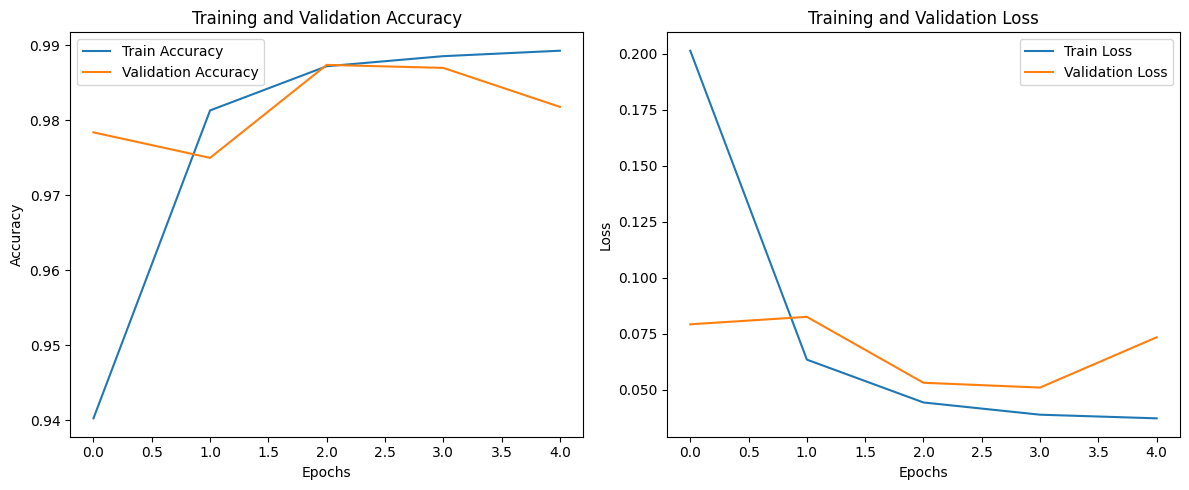

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy seems to be pretty high for both training and validation loss.

## Test Model

In [ ]:
# Test the model
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy = correct_test / total_test
test_losses.append(test_loss/len(test_loader))
test_accuracies.append(test_accuracy)

print(f"Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {test_accuracy}")

Test Loss: 0.07436180378103524, Test Accuracy: 0.9812


## Prediction on test dataset

In [ ]:
# Get all predictions and true labels from the test set
all_predictions = []
all_true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

## Classification Report

In [ ]:
# Generate the classification report
report = classification_report(all_true_labels, all_predictions, target_names=[str(i) for i in range(10)])
print(report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.96      0.98      1032
           3       0.96      0.99      0.98      1010
           4       1.00      0.98      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.97      0.98       958
           7       0.99      0.98      0.98      1028
           8       1.00      0.98      0.99       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## Confusion Matrix

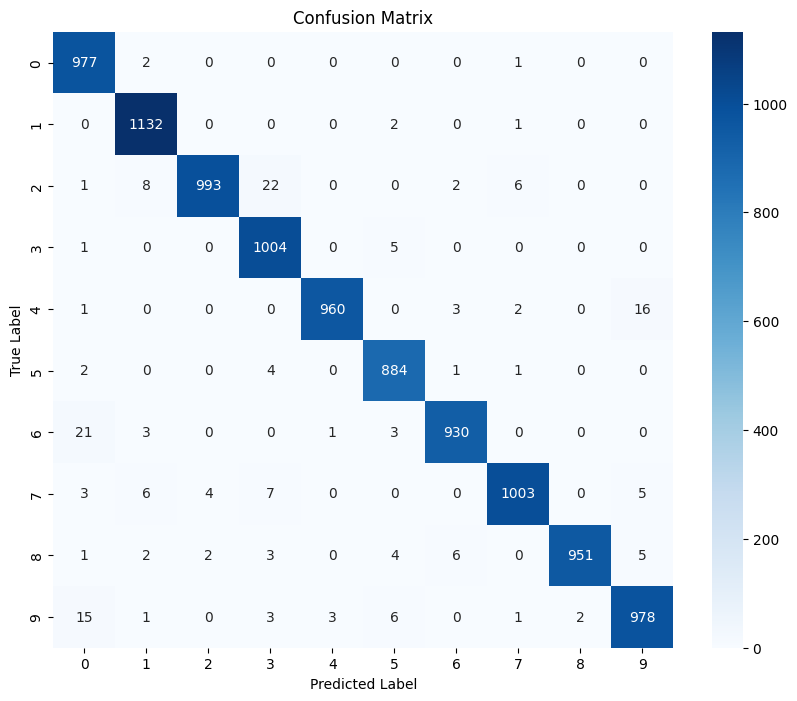

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

It is able to predict correctly.

## Random Samples

In [ ]:
# Randomly select 5 samples from the test data
random_indices = np.random.choice(len(mnist_test), 5, replace=False)
random_data_samples = [mnist_test[i][0] for i in random_indices]
random_label_samples = [mnist_test[i][1] for i in random_indices]

# Convert samples to DataLoader for batch processing
sample_loader = DataLoader(list(zip(random_data_samples, random_label_samples)), batch_size=5, shuffle=False)


In [ ]:
# Predict labels for the randomly selected samples
with torch.no_grad():
    for inputs, labels in sample_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        random_predictions = resnet_model(inputs)


In [ ]:
# Display the predictions alongside the actual labels
for i, (pred, actual) in enumerate(zip(random_predictions, labels)):
    print(f"Sample {i+1}: Predicted: {torch.argmax(pred).item()}, Actual: {actual.item()}")

Sample 1: Predicted: 7, Actual: 7
Sample 2: Predicted: 7, Actual: 7
Sample 3: Predicted: 6, Actual: 6
Sample 4: Predicted: 9, Actual: 9
Sample 5: Predicted: 0, Actual: 0


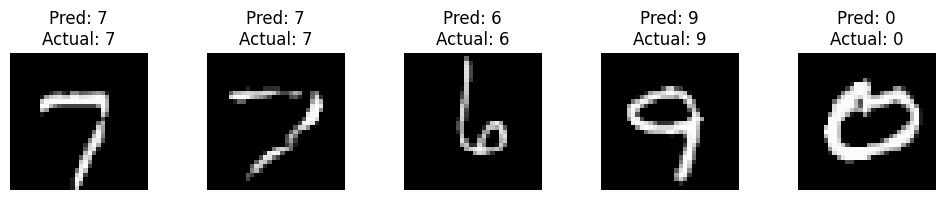

In [ ]:
# Display the images, predicted labels, and actual labels
plt.figure(figsize=(10, 2))
for i, (image, pred, actual) in enumerate(zip(random_data_samples, random_predictions, labels)):
    plt.subplot(1, 5, i+1)
    plt.imshow(image.cpu().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')  # Convert tensor to numpy for visualization
    plt.title(f"Pred: {torch.argmax(pred).item()}\nActual: {actual.item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Plant Disease Classification
## Mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Change directory. Uncomment this code to change and extract file. Please ensure following file is present.
This is a shared drive and I have given access to Dr. Jun Li only, so downloading of file and extracting is not required for Dr. Jun.
But if you want to run the code you need to download the file, extract it and update the path of file.
The kaggle link for the code is: https://www.kaggle.com/datasets/emmarex/plantdisease


In [ ]:
cd /gdrive/Shareddrives/32513/assignment/data/

/gdrive/Shareddrives/32513/assignment/data


In [ ]:
rm -rf PlantDisease

In [ ]:
rm -rf plantvillage

In [ ]:
ls

plant_disease_archive.zip


In [ ]:
!unzip plant_disease_archive.zip -d PlantDisease

Streaming output truncated to the last 5000 lines.
  inflating: PlantDisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: PlantDisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: PlantDisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: PlantDisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: PlantDisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: PlantDisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: PlantDisease

Ensure this path is correct.

In [ ]:
DATA_PATH="/gdrive/Shareddrives/32513/assignment/data/PlantDisease/PlantVillage"

## Load Dataset
Data Transformation
1. Resizes images to 224x224 pixels.
2. Converts images to PyTorch tensors.
3. Normalizes images using mean and standard deviation values from the ImageNet dataset.

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ResNet's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using values from ImageNet
])

In [ ]:
# Load the dataset
# Define a custom function to check if a file is valid based on its extension
def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.

    Args:
        filename (string): path to a file
        extensions (tuple of strings): extensions to consider (lowercase)

    Returns:
        bool: True if the filename ends with one of given extensions
    """
    return filename.lower().endswith(extensions)

# Modify the extensions to include .JPG
valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp', '.JPG')

# Load the dataset
# Since the file were .JPG, default validation with custom validation is added.
dataset = ImageFolder(DATA_PATH, transform=transform,
                      is_valid_file=lambda x: has_file_allowed_extension(x, valid_extensions))

In [ ]:
# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Create the ResNet50 model
resnet_model = ResNet50(num_classes=len(dataset.classes)).to(device)
# Define the loss function, optimizer, and metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters())

In [ ]:
# Lists to store loss and accuracy values for plotting
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []
# Initialize
gradient_per_epoch = {name: [] for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}
overall_gradient_sum = {name: 0 for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}
overall_gradient_count = {name: 0 for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}
layers_order = [name for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name]

## Train Model

In [ ]:
# Train the model
for epoch in range(5):
    # Training
    resnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    # Gradient stats initialization for this epoch
    gradient_stats = {name: 0 for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}
    gradient_count = {name: 0 for name, param in resnet_model.named_parameters() if param.requires_grad and "bias" not in name}

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient accumulation
        for name, param in resnet_model.named_parameters():
            if param.requires_grad and "bias" not in name:
                grad = param.grad.clone().detach().cpu()  # Move gradient to CPU
                gradient_stats[name] += grad.abs().sum().item()
                gradient_count[name] += grad.numel()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy = correct_train / total_train

    # Validation
    resnet_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = resnet_model(inputs)
            loss = criterion(val_outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(val_outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = correct_val / total_val

    # Append values to lists for plotting
    train_losses.append(running_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    # Store gradients for this epoch
    for name in gradient_per_epoch:
        gradient_per_epoch[name].append(gradient_stats[name] / gradient_count[name])
        overall_gradient_sum[name] += gradient_stats[name]
        overall_gradient_count[name] += gradient_count[name]

    print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {val_accuracy}")

Epoch 1, Train Loss: 1.306014753944051, Train Accuracy: 0.5780146753426554, Val Loss: 1.3160155280349182, Val Accuracy: 0.5909531502423263
Epoch 2, Train Loss: 0.7027497863545354, Train Accuracy: 0.7677557801467534, Val Loss: 0.827392403766052, Val Accuracy: 0.7909531502423264
Epoch 3, Train Loss: 0.47485961544170846, Train Accuracy: 0.8424477363976187, Val Loss: 0.3849067691060686, Val Accuracy: 0.8714054927302101
Epoch 4, Train Loss: 0.36368524980426364, Train Accuracy: 0.8791360930361346, Val Loss: 0.3639698069273811, Val Accuracy: 0.8804523424878837
Epoch 5, Train Loss: 0.27538224921223864, Train Accuracy: 0.9076560985739998, Val Loss: 0.31014815679530505, Val Accuracy: 0.8998384491114702


## Visualise Gradient Graph

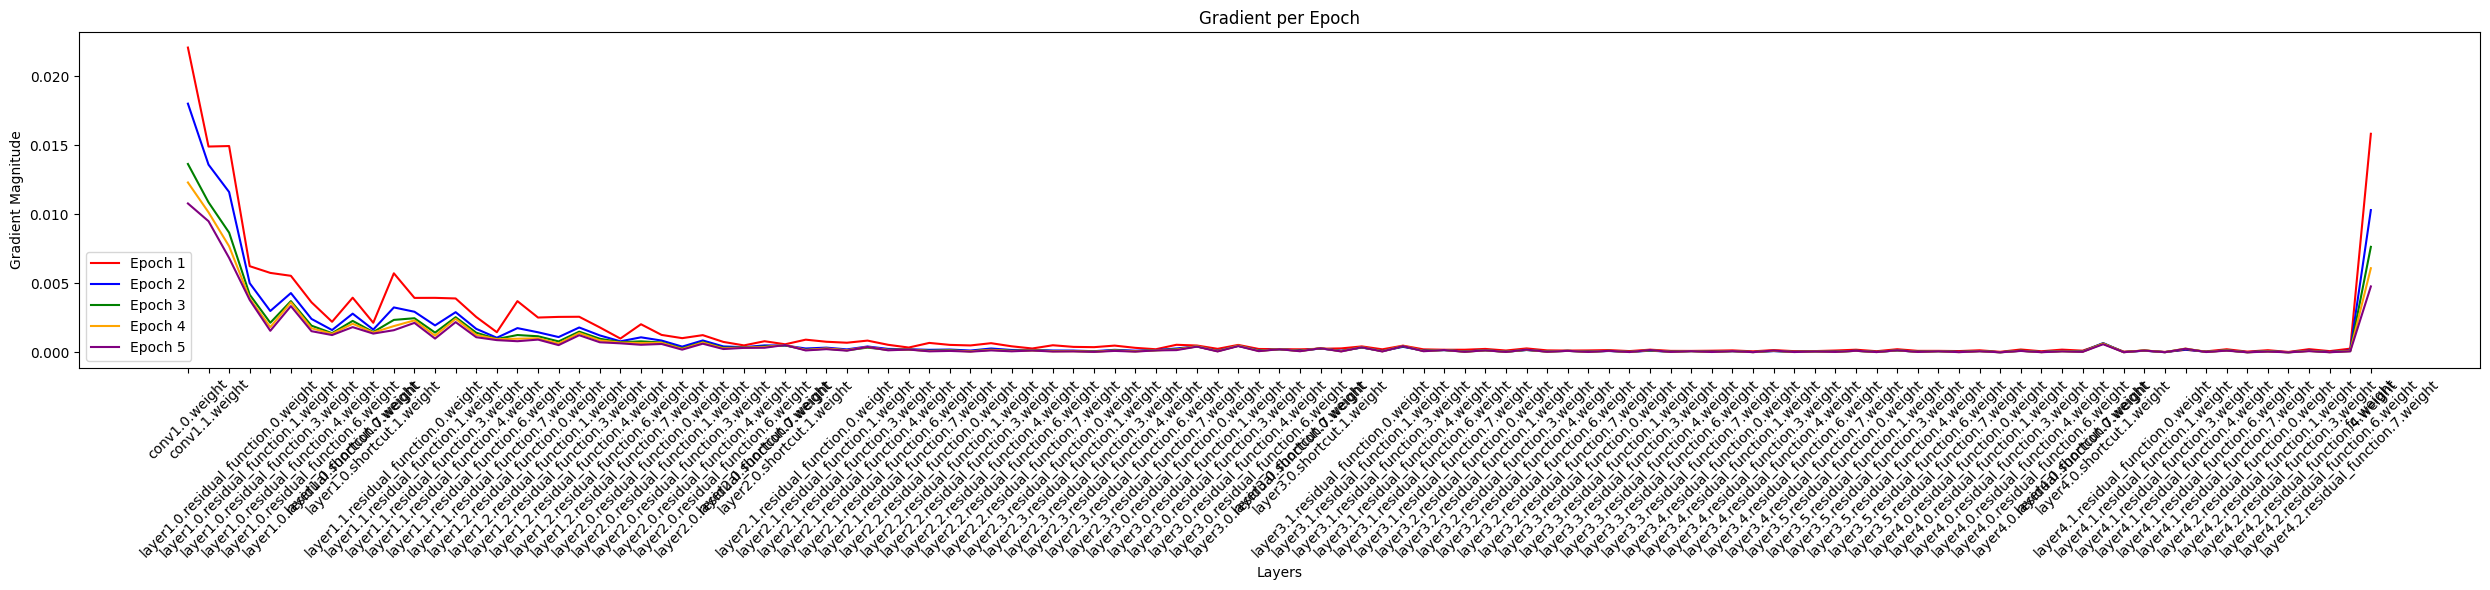

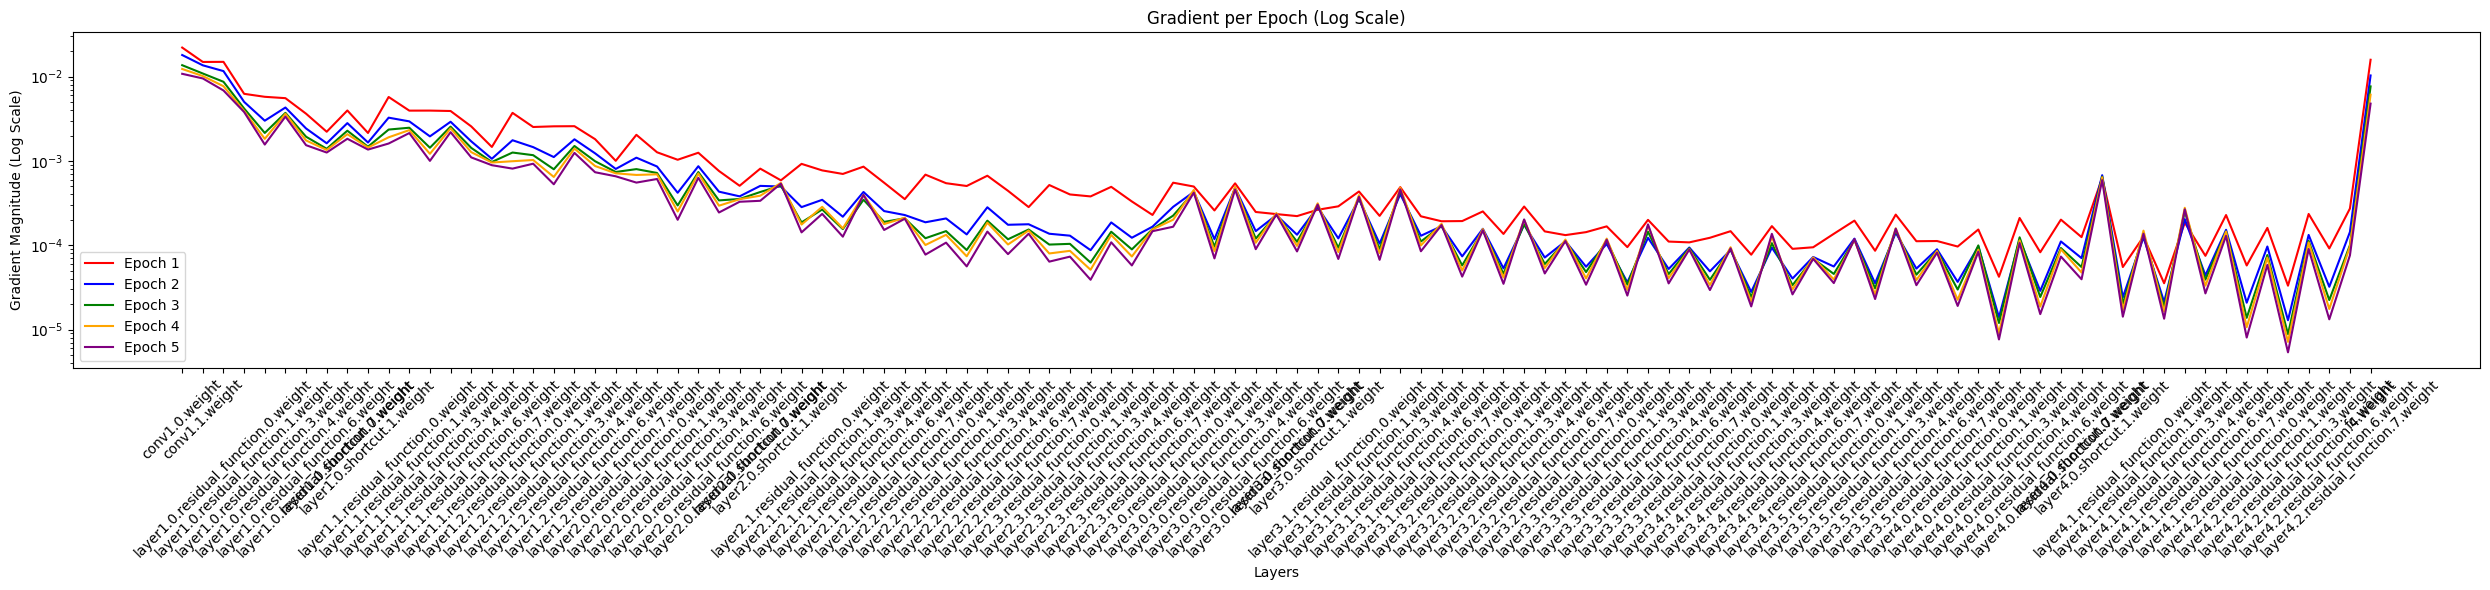

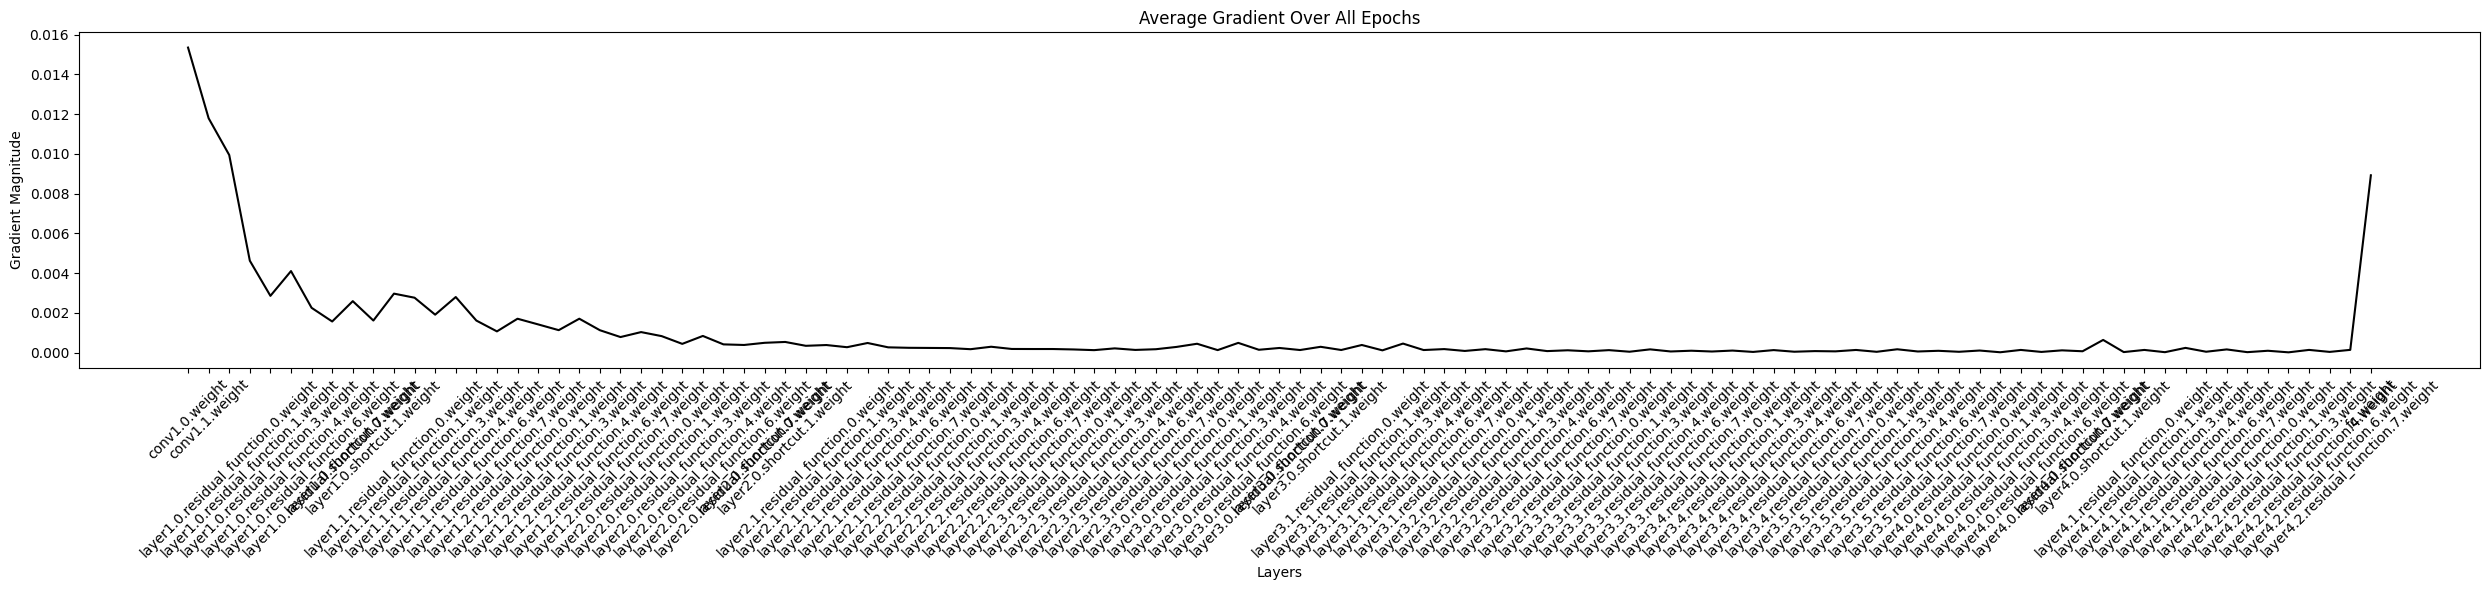

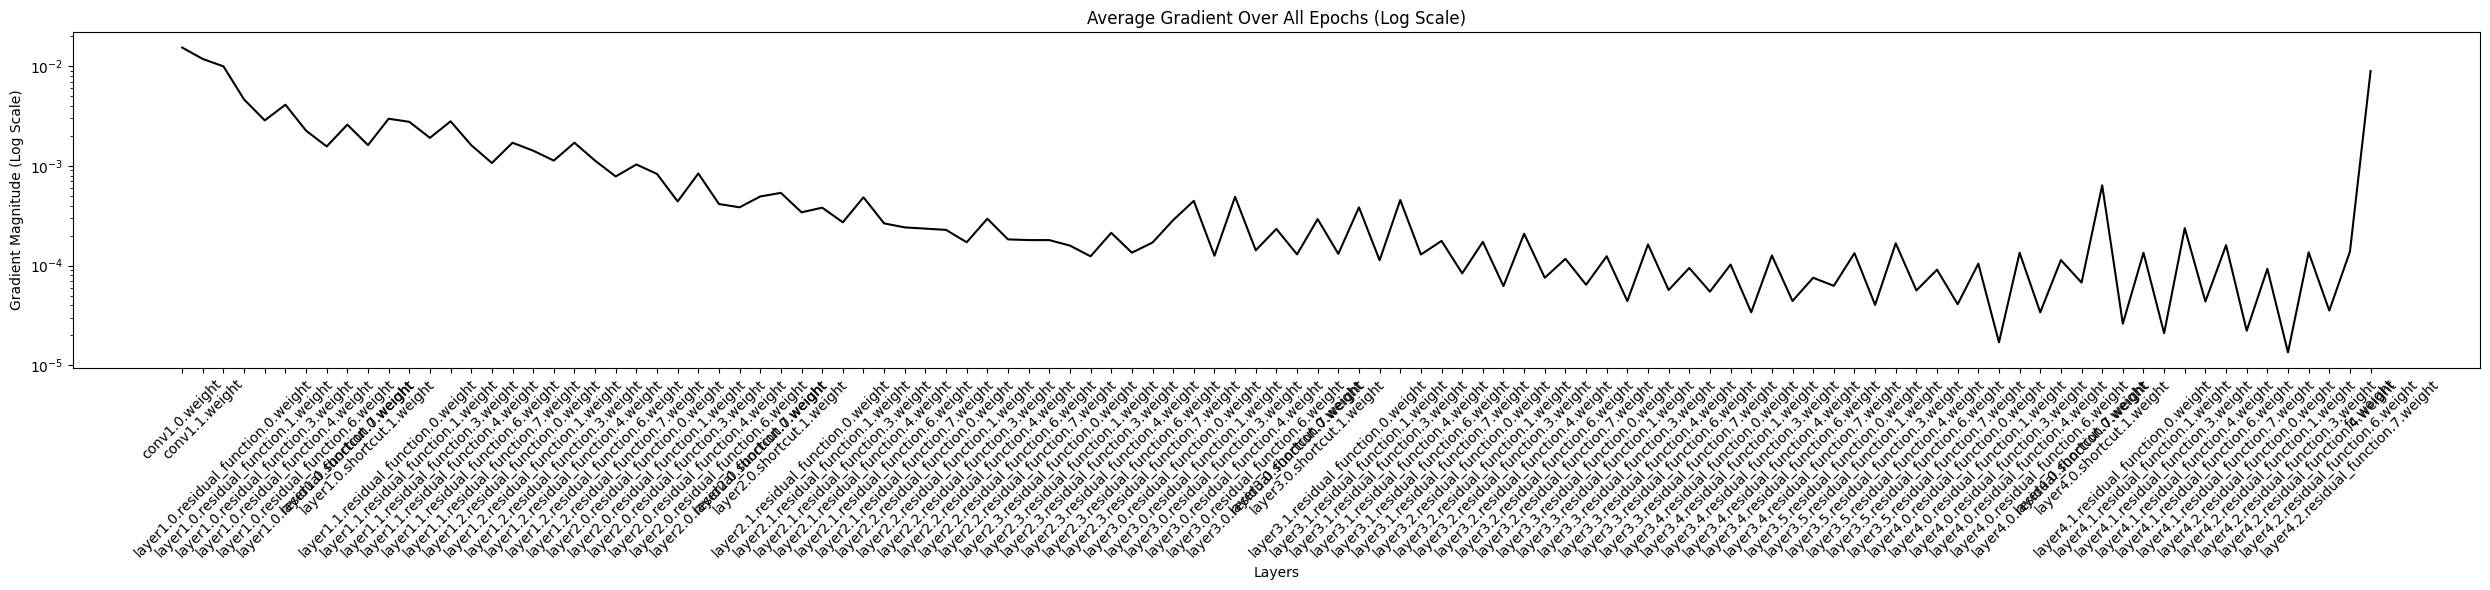

In [ ]:
# Compute average gradients over all epochs
average_gradients = {name: overall_gradient_sum[name] / overall_gradient_count[name] for name in gradient_per_epoch}

# Gradient per epoch on regular scale
fig, ax = plt.subplots(figsize=(25, 6))
for epoch, color in zip(range(5), ['red', 'blue', 'green', 'orange', 'purple']):
    gradients = [gradient_per_epoch[name][epoch] for name in layers_order]
    ax.plot(layers_order, gradients, label=f'Epoch {epoch + 1}', color=color)
ax.set_xlabel("Layers")
ax.set_ylabel("Gradient Magnitude")
ax.set_title("Gradient per Epoch")
ax.legend()
ax.set_xticks(layers_order)
ax.set_xticklabels(layers_order, rotation=45)
plt.tight_layout()
plt.show()

# Gradient per epoch on log scale
fig, ax = plt.subplots(figsize=(25, 6))
for epoch, color in zip(range(5), ['red', 'blue', 'green', 'orange', 'purple']):
    gradients = [gradient_per_epoch[name][epoch] for name in layers_order]
    ax.plot(layers_order, gradients, label=f'Epoch {epoch + 1}', color=color)
ax.set_yscale("log")
ax.set_xlabel("Layers")
ax.set_ylabel("Gradient Magnitude (Log Scale)")
ax.set_title("Gradient per Epoch (Log Scale)")
ax.legend()
ax.set_xticks(layers_order)
ax.set_xticklabels(layers_order, rotation=45)
plt.tight_layout()
plt.show()

# Average gradient on regular scale
fig, ax = plt.subplots(figsize=(25, 6))
avg_grads = [average_gradients[name] for name in layers_order]
ax.plot(layers_order, avg_grads, color='black')
ax.set_xlabel("Layers")
ax.set_ylabel("Gradient Magnitude")
ax.set_title("Average Gradient Over All Epochs")
ax.set_xticks(layers_order)
ax.set_xticklabels(layers_order, rotation=45)
plt.tight_layout()
plt.show()

# Average gradient on log scale
fig, ax = plt.subplots(figsize=(25, 6))
avg_grads = [average_gradients[name] for name in layers_order]
ax.plot(layers_order, avg_grads, color='black')
ax.set_yscale("log")
ax.set_xlabel("Layers")
ax.set_ylabel("Gradient Magnitude (Log Scale)")
ax.set_title("Average Gradient Over All Epochs (Log Scale)")
ax.set_xticks(layers_order)
ax.set_xticklabels(layers_order, rotation=45)
plt.tight_layout()
plt.show()


Analysis and Insights are similar to the Model with Residual Block so it's not mentioned in this part.

## Visualise Acc/Loss Graph

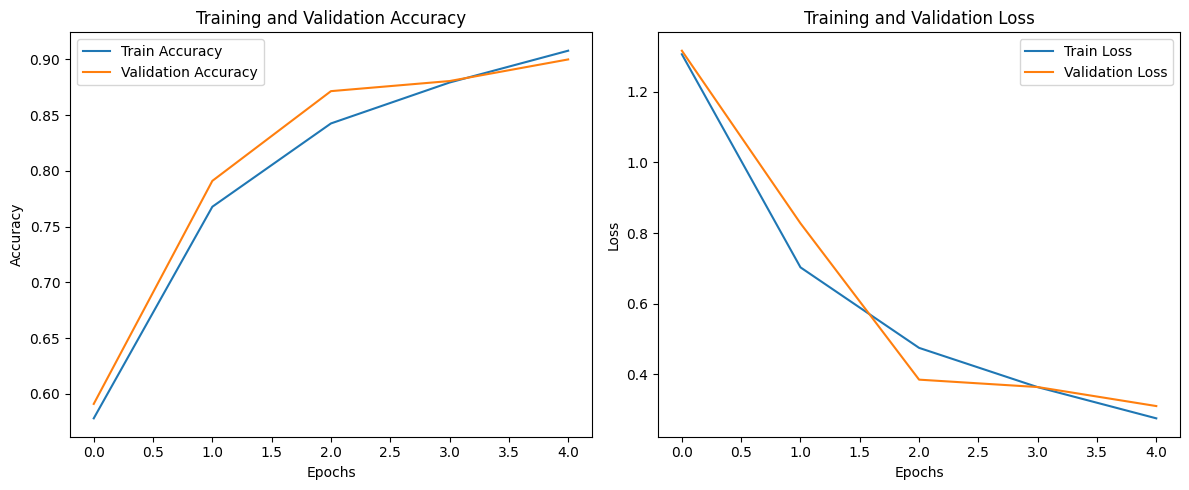

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Test Model

In [ ]:
# Test the model
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy = correct_test / total_test
test_losses.append(test_loss/len(test_loader))
test_accuracies.append(test_accuracy)

print(f"Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {test_accuracy}")

Test Loss: 0.3069442114264695, Test Accuracy: 0.897965773329028


## Prediction on test dataset

In [ ]:
LABELS = dataset.classes
# Get all predictions and true labels from the test set
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

## Classification Report

In [ ]:
# Generate the classification report
report = classification_report(all_true_labels, all_predictions, target_names=LABELS)
print(report)

## Confusion Matrix

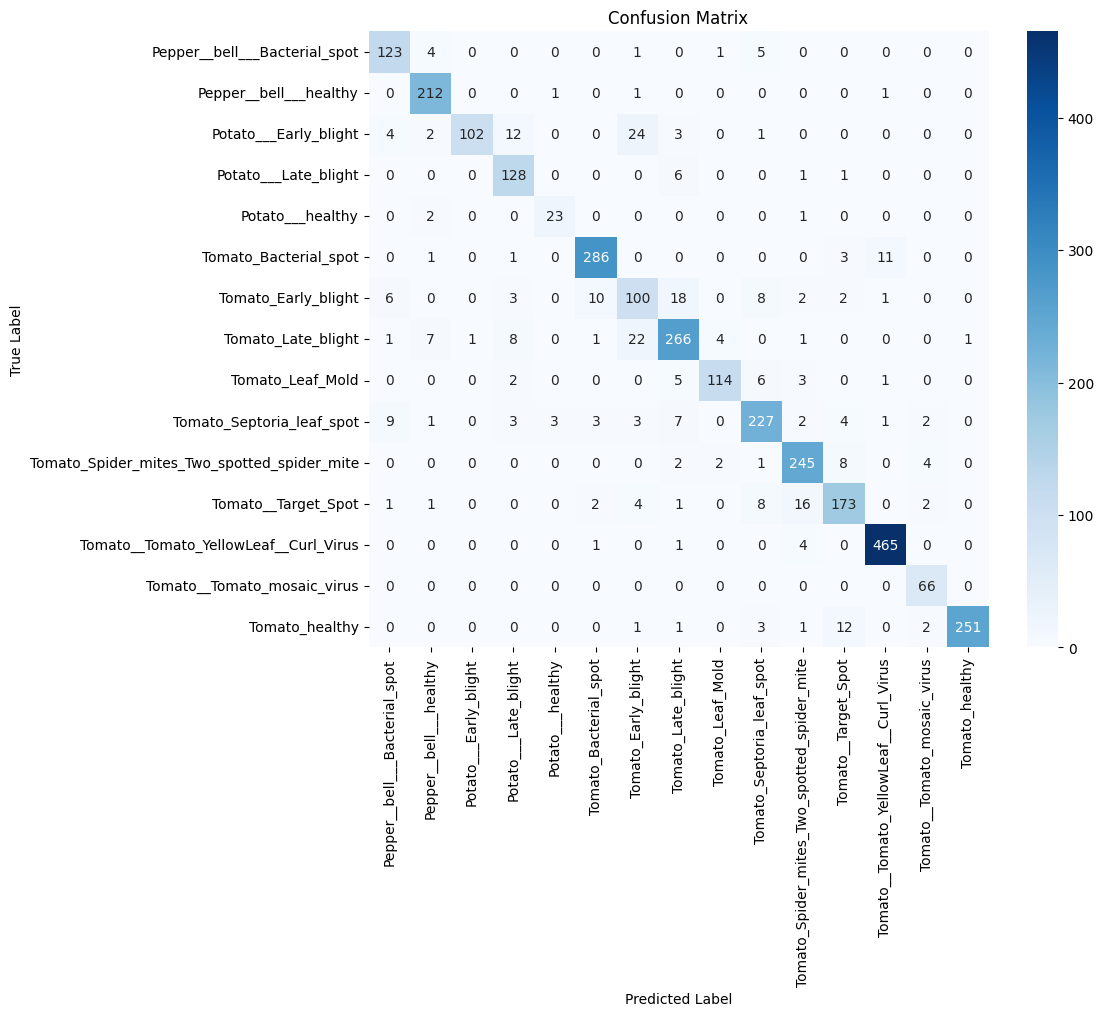

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Samples

In [ ]:
# Randomly select 5 samples from the test data
random_indices = np.random.choice(len(dataset), 5, replace=False)  # Use your actual test dataset reference here
random_data_samples = [dataset[i][0] for i in random_indices]
random_label_samples = [dataset[i][1] for i in random_indices]


In [ ]:
# Convert samples to DataLoader for batch processing
sample_loader = DataLoader(list(zip(random_data_samples, random_label_samples)), batch_size=5, shuffle=False)

# Predict labels for the randomly selected samples
with torch.no_grad():
    for inputs, labels in sample_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        random_predictions = resnet_model(inputs)


In [ ]:
# Display the predictions alongside the actual labels
for i, (pred, actual) in enumerate(zip(random_predictions, labels)):
    print(f"Sample {i+1}: Predicted: {LABELS[torch.argmax(pred).item()]}, Actual: {LABELS[actual.item()]}")

Sample 1: Predicted: Tomato_healthy, Actual: Tomato_healthy
Sample 2: Predicted: Tomato_Bacterial_spot, Actual: Tomato_Bacterial_spot
Sample 3: Predicted: Tomato_healthy, Actual: Tomato_healthy
Sample 4: Predicted: Tomato_Spider_mites_Two_spotted_spider_mite, Actual: Tomato_Spider_mites_Two_spotted_spider_mite
Sample 5: Predicted: Tomato__Target_Spot, Actual: Tomato_Bacterial_spot


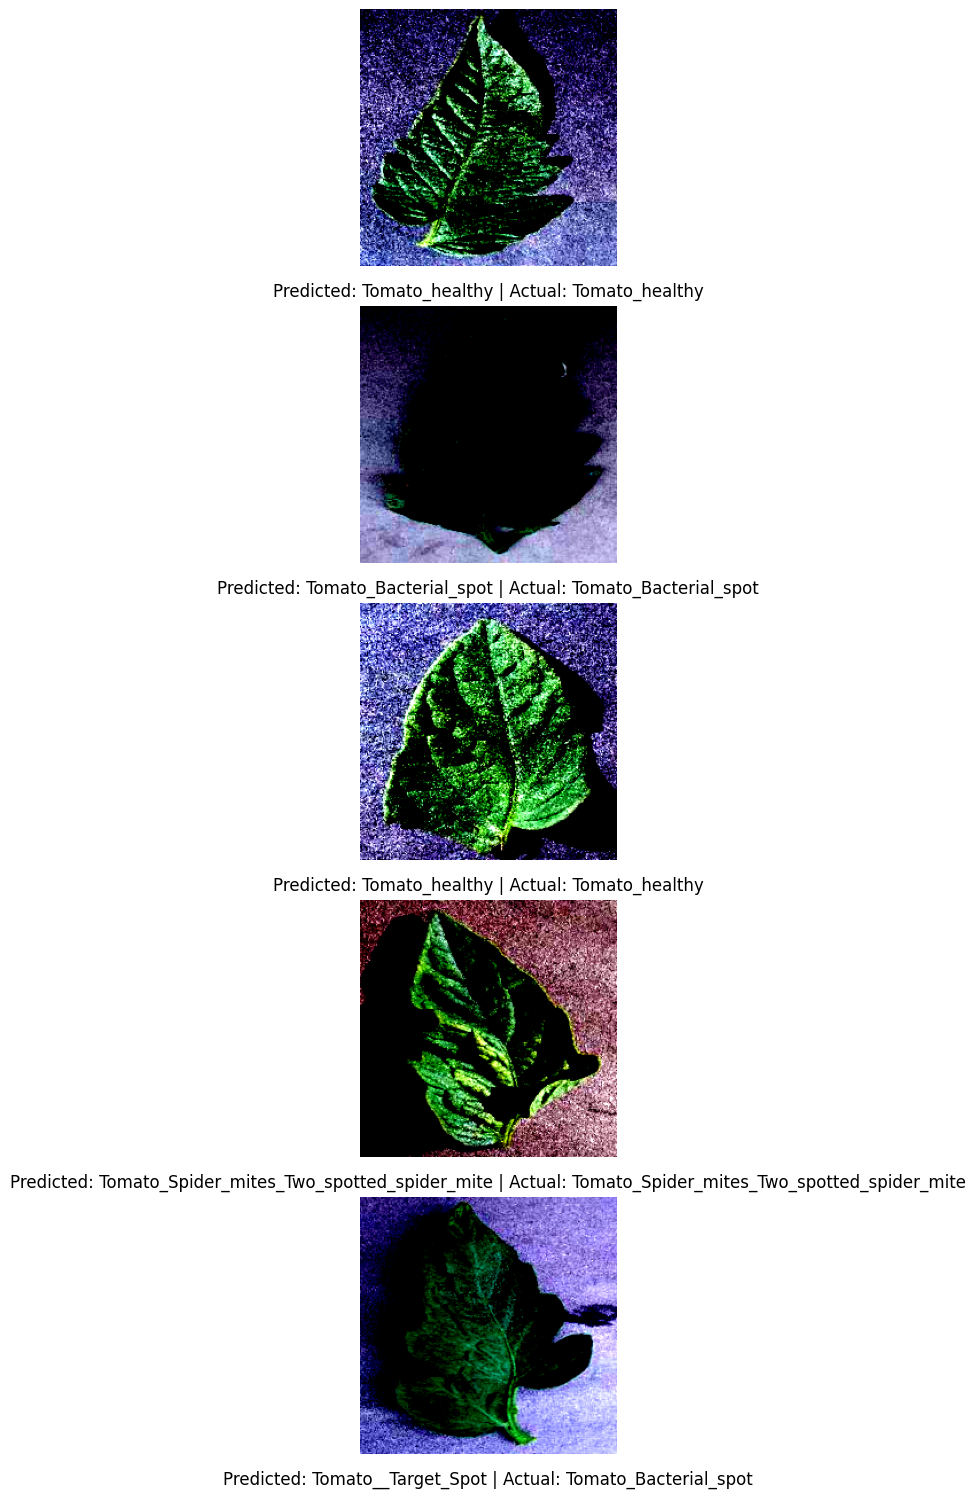

In [ ]:
# Increase the figure size for better visibility
num_samples = len(random_data_samples)
plt.figure(figsize=(15, 3 * num_samples))

for i, (image, pred, actual) in enumerate(zip(random_data_samples, random_predictions, labels)):
    plt.subplot(num_samples, 1, i+1)

    # Display the image
    plt.imshow(image.cpu().numpy().transpose(1, 2, 0).squeeze())
    plt.axis('off')

    # Show the title above the image
    pred_label = LABELS[torch.argmax(pred).item()]
    actual_label = LABELS[actual.item()]
    plt.title(f"Predicted: {pred_label} | Actual: {actual_label}", y=-0.15)

plt.tight_layout()
plt.show()

Analysis and Insights are similar to the Model with Residual Block so it's not mentioned in this part.

# Conclusion

Deep neural network has lot of challenges during training and testing model, one such problem vanishing or exploding gradients is studied in this code. Through the implementation of the ResNet architecture, it also demonstrated how residual connections can mitigate such challenges, enabling the successful training of very deep networks with great accuracy.

In [ ]:
from datetime import datetime
print(f"Assignment -Gribesh Dhakal (24594374). Last Executed: {datetime.now()}")

Assignment -Gribesh Dhakal (24594374). Last Executed: 2023-10-15 05:30:53.608883
